# Predicción de bancarrota empresarial

En este proyecto, se utilizan datos reales para predecir el si una empresa se declarará en bancarrota en el año siguiente a la observación de su información financiera. Para cada empresa, se tienen en total 63 razones financieras calculadas y la muestra corresponde a compañías en China durante los años de 1999 a 2009 que aparecen en el Shanghai Stock Exchange.

A continuación, se presentan las etapas para realizar un modelamiento predictivo de bancarrota empresarial mediante el uso de redes neuronales MLP. El informe se divide en las siguientes secciones:
1. Exploración de los datos (10 puntos)
2. Preparación de los datos (10 puntos)
3. Análisis preliminar de selección de modelos (20 puntos)
4. Desarrollo y calibración de modelos (40 puntos)
5. Visualización de resultados (20 puntos)

### Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import os
import shutil
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Nadam, Ftrl
from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import keras_tuner as kt
from keras_tuner import Objective
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Configuraciones estéticas
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


***
## 1. Exploración de los datos

La sección de Exploración de Datos tiene como objetivo entender la estructura, características y calidad del conjunto de datos. Aquí se realiza un análisis descriptivo inicial que incluye la revisión de las dimensiones del dataset, tipos de variables, valores faltantes, estadísticas descripotivas y patrones relevantes. 

Esta etapa es fundamental para identificar posibles inconsistencias, detectar tendencias o relaciones entre variables, y definir estrategias de limpieza y preparación de los datos para la etapa de preparación.

### Cargue de datos

In [2]:
# Cargar archivos (rutas relativas)
train = pd.read_csv("../data/raw/train_data.csv")
test = pd.read_csv("../data/raw/test_data.csv")
sample_submission = pd.read_csv("../data/raw/sampleSubmission.csv")

### Información general

#### Tamaño y visualización de los datasets

In [3]:
# Tamaño de los datasets
print("Tamaño Train:", train.shape)
print("Tamaño Test:", test.shape)

Tamaño Train: (2050, 65)
Tamaño Test: (500, 64)


In [4]:
train

ID  Bankruptcy  Realized.Sales.Gross.Profit.Growth.Rate  \
0        1           0                                 0.087661   
1        2           0                                 0.021892   
2        3           0                                 0.102249   
3        4           0                                 0.029972   
4        6           0                                 0.021164   
...    ...         ...                                      ...   
2045  2545           0                                 0.067900   
2046  2546           0                                 0.067735   
2047  2547           0                                 0.068447   
2048  2548           0                                 0.017600   
2049  2550           0                                 0.136419   

      Operating.Expense.Rate  Operating.Profit.Per.Share..Yuan...  \
0               1.900349e-04                             0.131094   
1               5.371576e-04                             0.086167   
2               2.178329e-04                             0.157755   
3               4.915756e+10                             0.249279   
4               1.206001e-04                             0.239817   
...                      ...                                  ...   
2045            7.201851e+05                             0.334972   
2046            2.380508e-05                             0.193017   
2047            8.325822e-05                             0.109198   
2048            9.098720e-03                             0.279550   
2049            4.421828e+07                             0.200310   

      Gross.Profit.to.Sales  Tax.rate..A.  Current.Liability.to.Liability  \
0                  0.583345      0.000000                        0.815892   
1                  0.695478      0.209649                        0.768636   
2                  0.766934      0.272061                        0.643316   
3                  0.611580      0.288357                        0.752782   
4                  0.614250      0.000000                        0.559498   
...                     ...           ...                             ...   
2045               0.564459      0.166696                        0.889719   
2046               0.736555      0.089094                        0.738665   
2047               0.734305      0.000000                        0.534512   
2048               0.757877      0.492404                        0.806436   
2049               0.561358      0.126222                        0.641650   

      Continuous.Net.Profit.Growth.Rate  \
0                              0.395719   
1                              0.163505   
2                              0.181571   
3                              0.409196   
4                              0.286989   
...                                 ...   
2045                           0.277489   
2046                           0.348624   
2047                           0.404424   
2048                           0.175130   
2049                           0.283364   

      Long.term.Liability.to.Current.Assets  ...  \
0                                  0.089276  ...   
1                                  0.000000  ...   
2                                  0.010180  ...   
3                                  0.018603  ...   
4                                  0.148687  ...   
...                                     ...  ...   
2045                               0.005494  ...   
2046                               0.007731  ...   
2047                               0.029523  ...   
2048                               0.014910  ...   
2049                               0.025015  ...   

      Per.Share.Net.profit.before.tax..Yuan...  \
0                                     0.223720   
1                                     0.324763   
2                                     0.360892   
3                                     0.152445   
4                                     0.217282   
...    

In [5]:
test.head(5)

ID  Realized.Sales.Gross.Profit.Growth.Rate  Operating.Expense.Rate  \
0   5                                 0.055077            1.064430e-02   
1  14                                 0.020286            6.654634e+07   
2  16                                 0.040610            8.415991e+08   
3  26                                 0.067641            1.344961e-04   
4  28                                 0.017546            6.125562e-03   

   Operating.Profit.Per.Share..Yuan...  Gross.Profit.to.Sales  Tax.rate..A.  \
0                             0.131220               0.657541      0.118122   
1                             0.247104               0.746134      0.000000   
2                             0.164832               0.718794      0.130647   
3                             0.153400               0.741510      0.000000   
4                             0.208468               0.743188      0.317456   

   Current.Liability.to.Liability  Continuous.Net.Profit.Growth.Rate  \
0                        0.771297                           0.366505   
1                        0.697656                           0.313514   
2                        0.398228                           0.239002   
3                        0.842550                           0.348637   
4                        0.387746                           0.175101   

   Long.term.Liability.to.Current.Assets  Total.assets.to.GNP.price  ...  \
0                               0.018675                   0.001246  ...   
1                               0.126093                   0.006813  ...   
2                               0.122627                   0.002547  ...   
3                               0.007500                   0.000219  ...   
4                               0.039756                   0.008112  ...   

   Per.Share.Net.profit.before.tax..Yuan...  \
0                                  0.197730   
1                                  0.254563   
2                                  0.186794   
3                                  0.401842   
4                                  0.329068   

   Continuous.interest.rate..after.tax.  Liability.Assets.Flag  \
0                              0.786381                      0   
1                              0.850153                      0   
2                              0.808544                      0   
3                              0.830902                      0   
4                              0.799609                      0   

   Working.Capital.to.Total.Assets  Degree.of.Financial.Leverage..DFL.  \
0                         0.828263                            0.024649   
1                         0.684968                            0.075233   
2                         0.888590                            0.078625   
3                         0.800685                            0.158704   
4                         0.824782                            0.136387   

   Operating.Gross.Margin  Contingent.liabilities.Net.worth  \
0                0.645659                          0.052743   
1                0.723486                          0.003821   
2                0.737439                          0.070270   
3                0.610681                          0.012037   
4                0.637626                          0.003518   

   Operating.Profit.Growth.Rate  Cash.Flow.to.Liability  \
0                      0.913336                0.557402   
1                      0.851428                0.584835   
2                      0.832491                0.409327   
3                      0.824596                0.561291   
4                      0.900079                0.477007   

   Quick.Assets.Total.Assets  
0                   0.360819  
1                   0.058199  
2                   0.449420  
3                   0.449031  
4                   0.395706  

[5 rows x 64 columns]

#### Tipos de datos

La exploración se enfoca en el dataset de train, ya que es el conjunto de datos que se utilizará para el desarrollo de los modelos predictivos.

La variable objetivo es "Bankruptcy", la cual es una variable binaria que toma el valor de 1 si la empresa está en bancarrota y 0 si no lo está.

In [6]:
# Tipos de datos y valores nulos
# train.info()

La siguiente tabla muestra las variables, el tipo de dato y una descripción interpretada a partir de sus nombres, con el proposito de entender mejor la naturaleza e importancia de cada variable.

| Variable original | Traducción al español | Descripción | Tipo de dato |
|-------------------|-----------------------|----------------------|--------------|
| ID | ID | Identificador único de la observación | int |
| Bankruptcy | Quiebra | Variable objetivo (0 = no quebró, 1 = quebró) | int |
| Realized.Sales.Gross.Profit.Growth.Rate | Tasa de crecimiento del beneficio bruto sobre ventas realizadas | Mide el crecimiento del beneficio bruto | float |
| Operating.Expense.Rate | Tasa de gastos operativos | Gastos operativos / Ingresos | float |
| Operating.Profit.Per.Share..Yuan... | Beneficio operativo por acción (en Yuanes) | Utilidad operativa / Número de acciones | float |
| Gross.Profit.to.Sales | Beneficio bruto sobre ventas | Margen bruto | float |
| Tax.rate..A. | Tasa impositiva (A) | Tasa efectiva de impuestos | float |
| Current.Liability.to.Liability | Pasivo corriente / Pasivo total | Proporción de deuda de corto plazo | float |
| Continuous.Net.Profit.Growth.Rate | Tasa de crecimiento continuo de la utilidad neta | Crecimiento neto interanual | float |
| Long.term.Liability.to.Current.Assets | Pasivo a largo plazo / Activos corrientes | Indicador de solvencia | float |
| Total.assets.to.GNP.price | Activos totales sobre precio del PIB | Relación entre activos y economía nacional | float |
| Current.Liabilities.Equity | Pasivo corriente / Patrimonio | Proporción de deuda de corto plazo sobre capital | float |
| CFO.to.Assets | Flujo operativo / Activos totales | Eficiencia en generación de flujo | float |
| Current.Liability.to.Current.Assets | Pasivo corriente / Activos corrientes | Índice de liquidez corriente | float |
| Persistent.EPS.in.the.Last.Four.Seasons | EPS persistente en los últimos 4 trimestres | Consistencia de las ganancias | float |
| Cash.Total.Assets | Efectivo / Activos totales | Nivel de liquidez | float |
| Inventory.Working.Capital | Inventario / Capital de trabajo | Proporción del inventario dentro del capital disponible | float |
| Net.Value.Per.Share..B. | Valor neto por acción (B) | Versión B del valor contable por acción | float |
| Current.Assets.Total.Assets | Activos corrientes / Activos totales | Proporción de activos líquidos | float |
| Net.Worth.Turnover.Rate..times. | Rotación del patrimonio neto | Ventas / Patrimonio neto | float |
| Interest.Coverage.Ratio..Interest.expense.to.EBIT. | Cobertura de intereses | Capacidad para pagar intereses | float |
| Equity.to.Liability | Patrimonio / Pasivo | Apalancamiento | float |
| Operating.profit.Paid.in.capital | Beneficio operativo / Capital pagado | Retorno sobre capital | float |
| No.credit.Interval | Intervalo sin crédito | Tiempo en que la empresa no accedió a créditos | float |
| Interest.bearing.debt.interest.rate | Tasa de interés de deuda con interés | Costo del financiamiento | float |
| Net.Income.to.Stockholder.s.Equity | Utilidad neta / Patrimonio del accionista | Rentabilidad sobre capital (ROE) | float |
| Quick.Ratio | Razón rápida | Liquidez sin inventario | float |
| Cash.Flow.to.Sales | Flujo de caja / Ventas | Conversión de ventas en efectivo | float |
| Equity.to.Long.term.Liability | Patrimonio / Pasivo de largo plazo | Cobertura del capital ante deudas largas | float |
| Working.Capital.Equity | Capital de trabajo / Patrimonio | Liquidez frente al capital | float |
| After.tax.net.Interest.Rate | Rentabilidad neta después de impuestos | Ganancia neta final | float |
| Current.Liability.to.Assets | Pasivo corriente / Activos totales | Presión de deuda de corto plazo | float |
| Net.Value.Per.Share..C. | Valor neto por acción (C) | Otra versión de valor contable por acción | float |
| Revenue.per.person | Ingresos por persona | Eficiencia del personal | float |
| Borrowing.dependency | Dependencia de préstamos | Proporción de financiación externa | float |
| Operating.Profit.Rate | Tasa de beneficio operativo | Rentabilidad operativa | float |
| Long.term.fund.suitability.ratio..A. | Índice de adecuación de fondos a largo plazo (A) | ¿Fondos de largo plazo cubren activos largos? | float |
| Pre.tax.net.Interest.Rate | Rentabilidad antes de impuestos | Rentabilidad sin impuestos | float |
| After.tax.Net.Profit.Growth.Rate | Tasa de crecimiento de la utilidad neta (post impuestos) | Medida de crecimiento real | float |
| Operating.profit.per.person | Beneficio operativo por persona | Productividad por empleado | float |
| Realized.Sales.Gross.Margin | Margen bruto sobre ventas realizadas | % de ganancia bruta | float |
| Cash.Current.Liability | Efectivo / Pasivo corriente | Liquidez inmediata | float |
| Current.Liability.to.Equity | Pasivo corriente / Patrimonio | Riesgo de corto plazo | float |
| Total.expense.Assets | Gasto total / Activos | Costo relativo de operación | float |
| Current.Asset.Turnover.Rate | Rotación de activos corrientes | Eficiencia en uso de activos | float |
| Fixed.Assets.Turnover.Frequency | Frecuencia de rotación de activos fijos | Intensidad de uso de maquinaria y propiedades | float |
| ROA.B..before.interest.and.depreciation.after.tax | Rentabilidad sobre activos antes de intereses y depreciación, después de impuestos | Versión de ROA ajustada | float |
| Quick.Asset.Turnover.Rate | Rotación de activos líquidos | Qué tan rápido se usan activos fácilmente convertibles | float |
| Debt.ratio.. | Razón de endeudamiento | Pasivo / Activos totales | float |
| Retained.Earnings.to.Total.Assets | Utilidades retenidas / Activos totales | Reinversión | float |
| Total.debt.Total.net.worth | Deuda total / Patrimonio neto | Apalancamiento | float |
| Fixed.Assets.to.Assets | Activos fijos / Activos totales | Proporción de activos no líquidos | float |
| Total.Asset.Growth.Rate | Tasa de crecimiento de activos totales | Expansión de la empresa | float |
| Inventory.and.accounts.receivable.Net.value | Valor neto de inventario y cuentas por cobrar | Activos circulantes clave | float |
| Net.Income.Flag | Indicador binario de ingreso neto | Flag de ganancia positiva | int |
| Per.Share.Net.profit.before.tax..Yuan... | Utilidad neta por acción antes de impuestos (en Yuanes) | Ganancia previa a impuestos por acción | float |
| Continuous.interest.rate..after.tax. | Tasa continua de interés neto después de impuestos | Rentabilidad constante ajustada | float |
| Liability.Assets.Flag | Indicador binario de pasivo sobre activos | ¿Relación riesgo-alto? | int |
| Working.Capital.to.Total.Assets | Capital de trabajo / Activos totales | Liquidez general | float |
| Degree.of.Financial.Leverage..DFL. | Grado de apalancamiento financiero | Qué tanto se depende de deuda para generar beneficios | float |
| Operating.Gross.Margin | Margen bruto operativo | Rentabilidad sin considerar impuestos y financieros | float |
| Contingent.liabilities.Net.worth | Pasivos contingentes / Patrimonio neto | Riesgo legal/potencial | float |
| Operating.Profit.Growth.Rate | Tasa de crecimiento del beneficio operativo | Evolución operativa | float |
| Cash.Flow.to.Liability | Flujo de efectivo / Pasivo total | Capacidad de pago | float |
| Quick.Assets.Total.Assets | Activos líquidos / Activos totales | Liquidez inmediata frente al total del negocio | float |


#### Estadístias descriptivas

In [7]:
# Estadísticas descriptivas
train.describe().T

count          mean           std  \
ID                                       2050.0  1.276675e+03  7.337705e+02   
Bankruptcy                               2050.0  3.024390e-02  1.712995e-01   
Realized.Sales.Gross.Profit.Growth.Rate  2050.0  5.242644e-02  3.734597e-02   
Operating.Expense.Rate                   2050.0  1.143592e+10  6.637064e+10   
Operating.Profit.Per.Share..Yuan...      2050.0  1.684231e-01  7.482216e-02   
...                                         ...           ...           ...   
Operating.Gross.Margin                   2050.0  6.595301e-01  6.430054e-02   
Contingent.liabilities.Net.worth         2050.0  2.062910e-02  1.928225e-02   
Operating.Profit.Growth.Rate             2050.0  8.707365e-01  2.806991e-02   
Cash.Flow.to.Liability                   2050.0  5.284203e-01  8.417075e-02   
Quick.Assets.Total.Assets                2050.0  4.621027e-01  2.114766e-01   

                                              min         25%          50%  \
ID                                       1.000000  645.250000  1286.500000   
Bankruptcy                               0.000000    0.000000     0.000000   
Realized.Sales.Gross.Profit.Growth.Rate  0.005576    0.022660     0.039844   
Operating.Expense.Rate                   0.000018    0.000387     0.002891   
Operating.Profit.Per.Share..Yuan...      0.026690    0.107202     0.153541   
...                                           ...         ...          ...   
Operating.Gross.Margin                   0.449928    0.608820     0.654584   
Contingent.liabilities.Net.worth         0.001931    0.005786     0.012352   
Operating.Profit.Growth.Rate             0.808653    0.848945     0.869933   
Cash.Flow.to.Liability                   0.078139    0.462781     0.519719   
Quick.Assets.Total.Assets                0.004725    0.295769     0.458141   

                                                  75%           max  
ID                                       1.902750e+03  2.550000e+03  
Bankruptcy                               0.000000e+00  1.000000e+00  
Realized.Sales.Gross.Profit.Growth.Rate  7.413378e-02  1.976222e-01  
Operating.Expense.Rate                   2.040574e+06  8.153957e+11  
Operating.Profit.Per.Share..Yuan...      2.197845e-01  4.024868e-01  
...                                               ...           ...  
Operating.Gross.Margin                   7.120428e-01  8.083387e-01  
Contingent.liabilities.Net.worth         2.978119e-02  9.671401e-02  
Operating.Profit.Growth.Rate             8.936929e-01  9.212760e-01  
Cash.Flow.to.Liability                   5.964921e-01  1.000000e+00  
Quick.Assets.Total.Assets                6.208409e-01  9.896206e-01  

[65 rows x 8 columns]

### Histogramas

Se generaron histogramas para cada variable

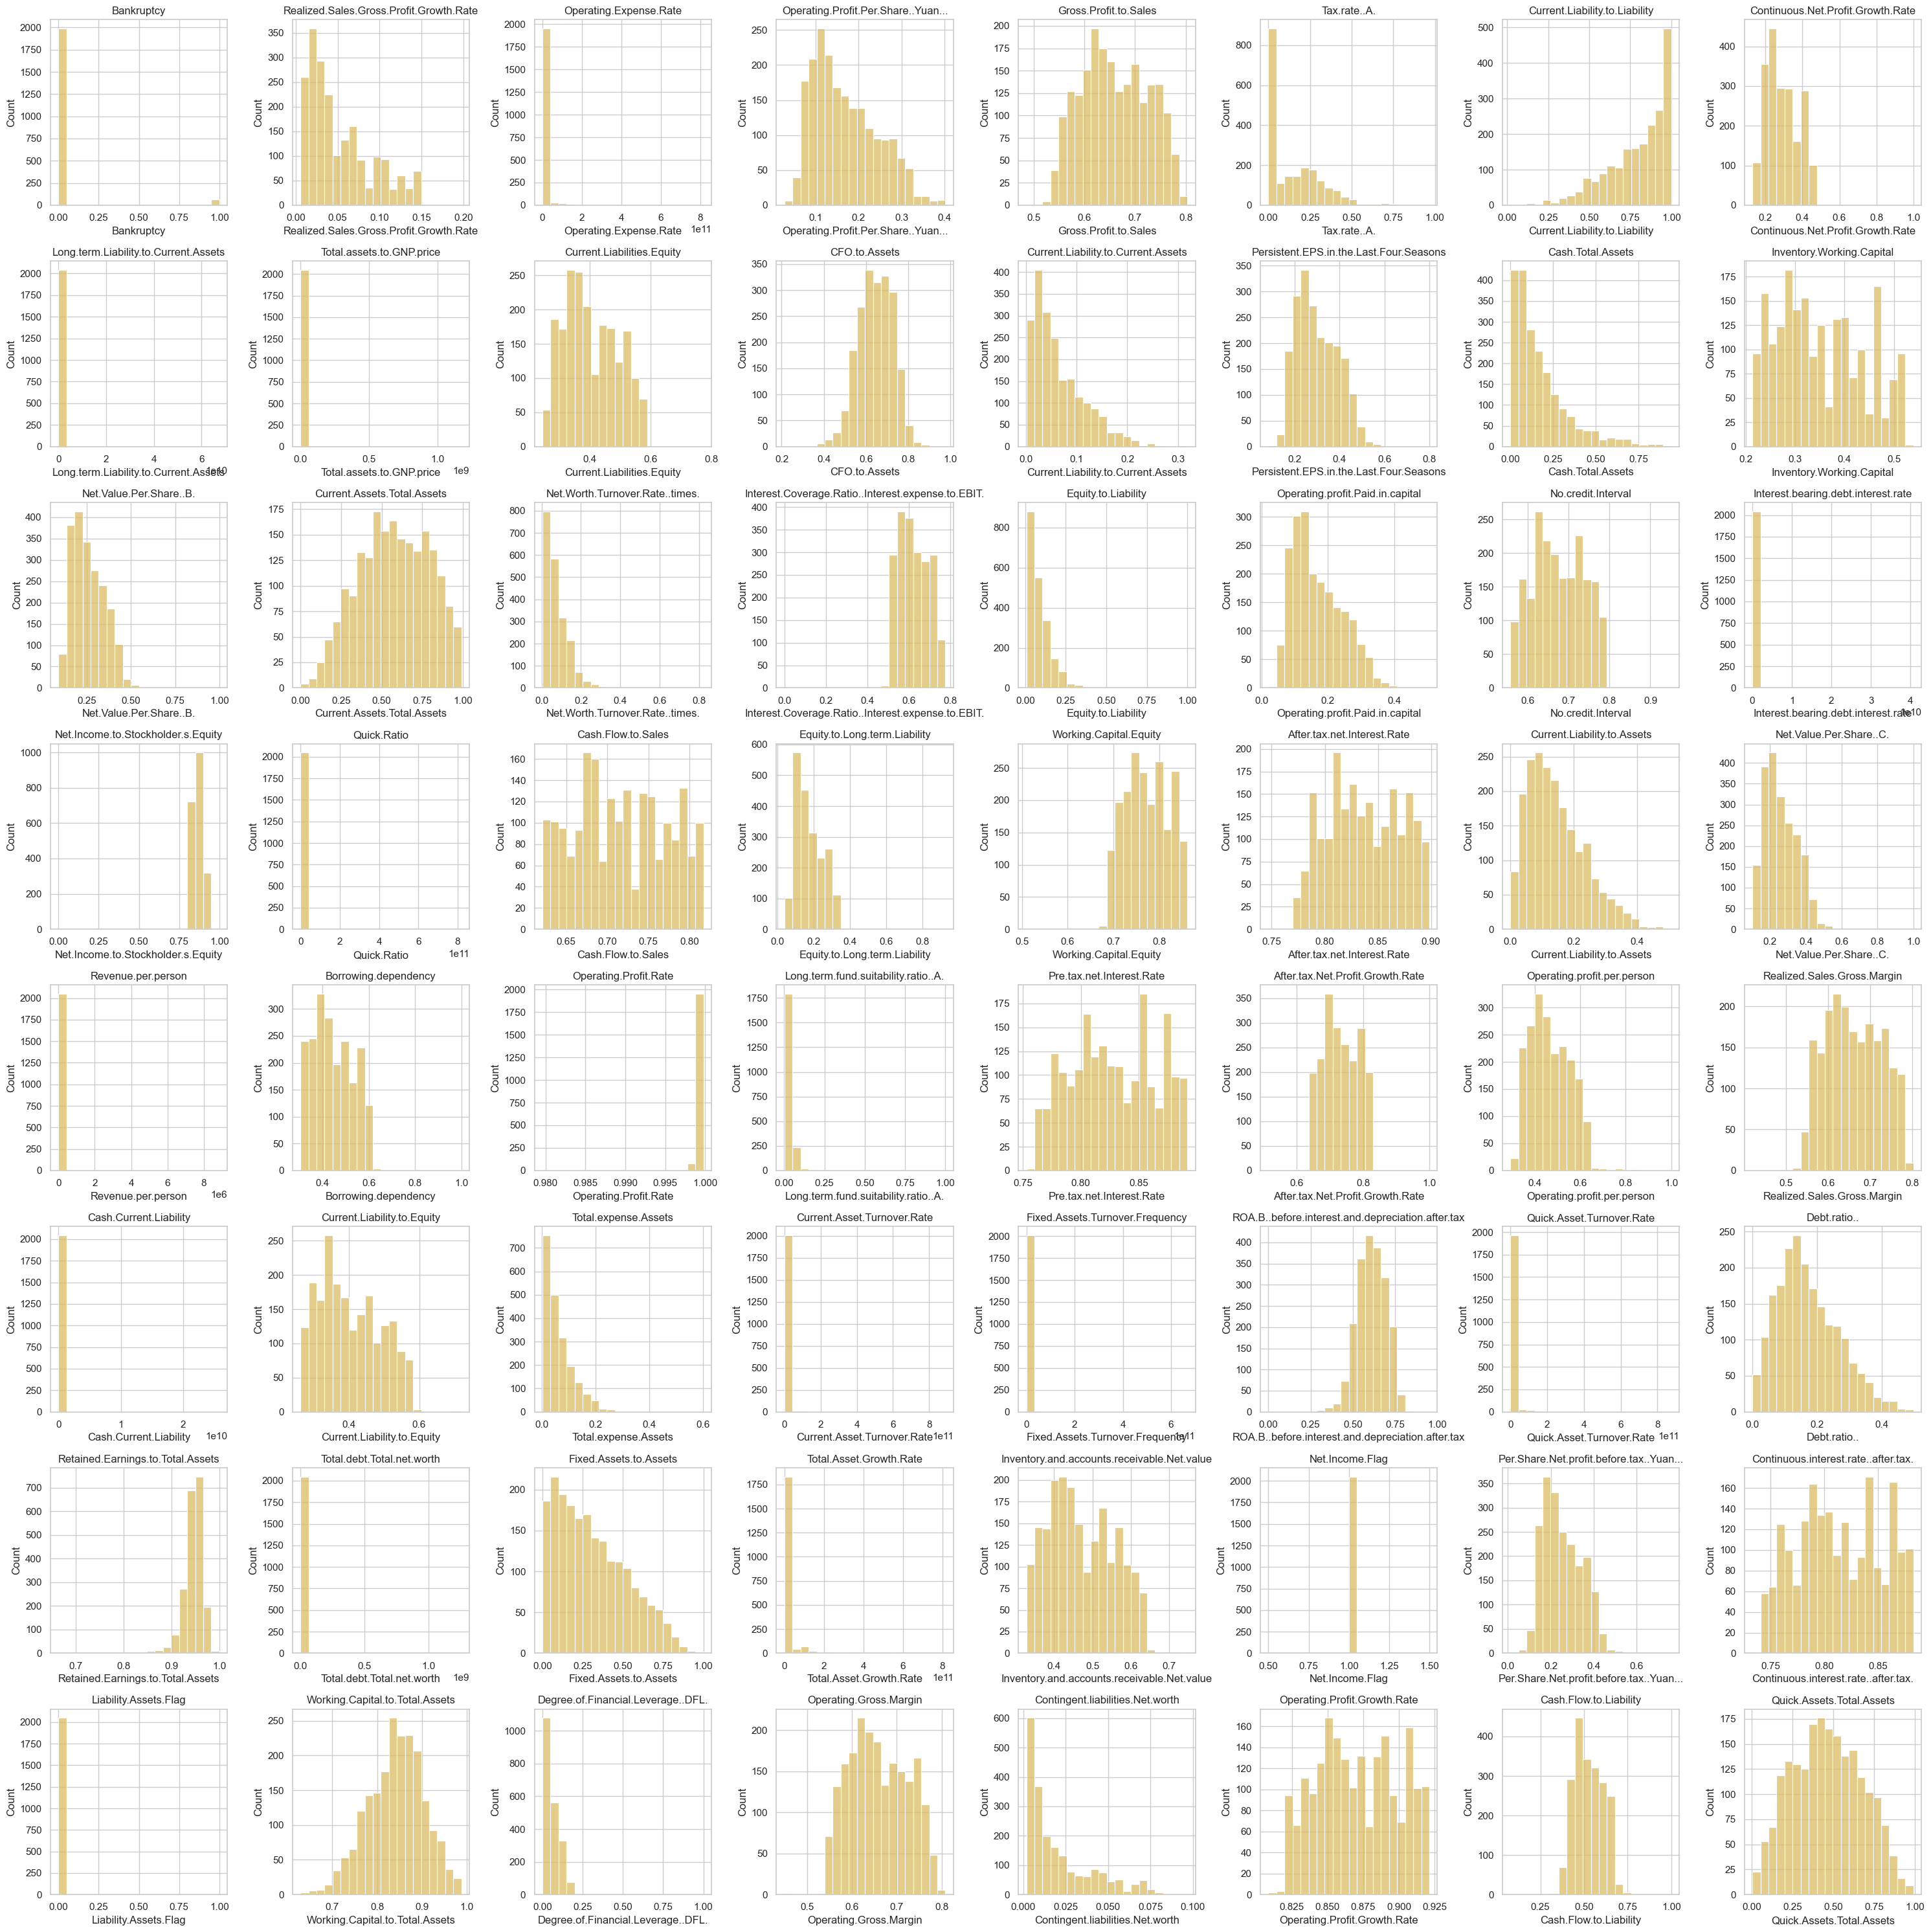

In [8]:
# Distribuciones de variables
columns_f = [col for col in train.columns if col != 'ID']

# Crear una figura con subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(30, 30))
axes = axes.flatten()

# Graficar los histogramas para cada variable
for i, column in enumerate(columns_f):
    sns.histplot(train[column], kde=False, ax=axes[i], bins=20, color="#dcbb65")
    axes[i].set_title(column)

# Ajustar los márgenes para que las etiquetas no se solapen
plt.tight_layout()
plt.show()

Observando los histogramas se tiene que:
- La mayoría de las variables presentan distribuciones asimétricas (sesgo positivo o sesgo a la derecha), donde una gran concentración de observaciones se encuentra en valores bajos y colas prolongadas hacia valores más altos.
- Algunas variables muestran distribuciones relativamente centradas y acotadas, lo que sugiere que podrían haber sido normalizadas o estandarizadas cuando se calcularon las razones financieras.

- Se observan algunos histogramas con colas largas y valores aislados, indicando la presencia potencial de outliers o datos extremos que podrían requerir tratamiento posterior.

- Un número limitado de variables exhibe más de un pico en su distribución, indicando posibles subgrupos dentro de los datos.

- No todas las variables comparten la misma escala, lo que sugiere la necesidad de aplicar técnicas de normalización en la etapa de preparación de datos.

Se genera el histograma de la variable objetivo para determinar si está o no balanceada.

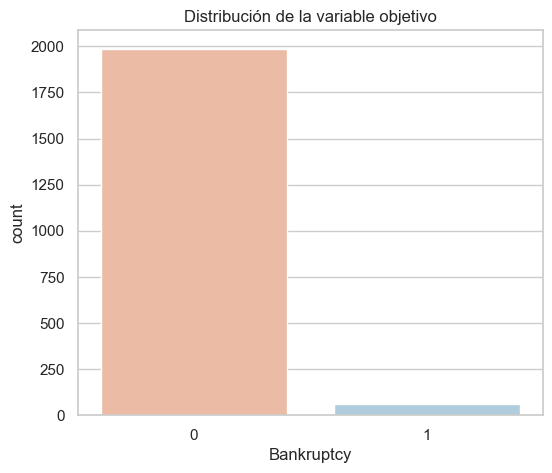

Tasa de bancarrota: 3.02%


In [9]:
# Distribución de la variable objetivo
plt.figure(figsize=(6, 5))  
sns.countplot(x='Bankruptcy', hue='Bankruptcy', data=train, palette='RdBu', legend=False)
plt.title('Distribución de la variable objetivo')
plt.show()

# Porcentaje de casos positivos (bancarrota)
bankrupt_rate = train['Bankruptcy'].mean()
print(f"Tasa de bancarrota: {bankrupt_rate:.2%}")

La variable objetivo Bankruptcy muestra una distribución altamente desbalanceada. La proporción de empresas en bancarrota es del 3.02%. Esto sugiere la aplicación de técnicas de balanceo.

### Detección de valores faltantes y duplicados

Se calcula a continuación, el porcentaje de valor nulos y número de registros duplicados por cada columna.

In [10]:
# Porcentaje de valores nulos por columna
nulls = train.isnull().mean().sort_values(ascending=False)
nulls[nulls > 0]

Series([], dtype: float64)

In [11]:
# Validar duplicados exactos (todas las columnas)
duplicados = train.duplicated()
print(f"Número de registros duplicados: {duplicados.sum()}")


Número de registros duplicados: 0


Todos los datos disponibles están completos y cada registro es único en el conjunto de entrenamiento.

### Valores atípicos

Se aplica la regla del rango intercuartílico (IQR) para determinar si existen valores atípicos. 

In [12]:
# Selección de variables numéricas (excluyendo la variable objetivo)
variables_numericas = train.drop(columns=['Bankruptcy', 'Net.Income.Flag']).select_dtypes(include='number').columns

# Función para detectar valores atípicos usando el rango intercuartílico (IQR)
def detectar_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    return outliers.shape[0]

# Número de valores atípicos por columna
outliers_por_col = {col: detectar_outliers_iqr(train, col) for col in variables_numericas}
outliers_df = pd.DataFrame.from_dict(outliers_por_col, orient='index', columns=['N_outliers'])
outliers_df.sort_values(by='N_outliers', ascending=False)


N_outliers
Operating.Expense.Rate                  485
Quick.Asset.Turnover.Rate               463
Fixed.Assets.Turnover.Frequency         417
Current.Asset.Turnover.Rate             400
Total.Asset.Growth.Rate                 383
...                                     ...
Cash.Flow.to.Sales                        0
Current.Assets.Total.Assets               0
Inventory.Working.Capital                 0
Gross.Profit.to.Sales                     0
Quick.Assets.Total.Assets                 0

[63 rows x 1 columns]

Varias variables presentan valores atípicos.

### Correlaciones

Se calcula la matriz de correlaciones de Pearson para todas las variables y se grafican mediante un mapa de calor.

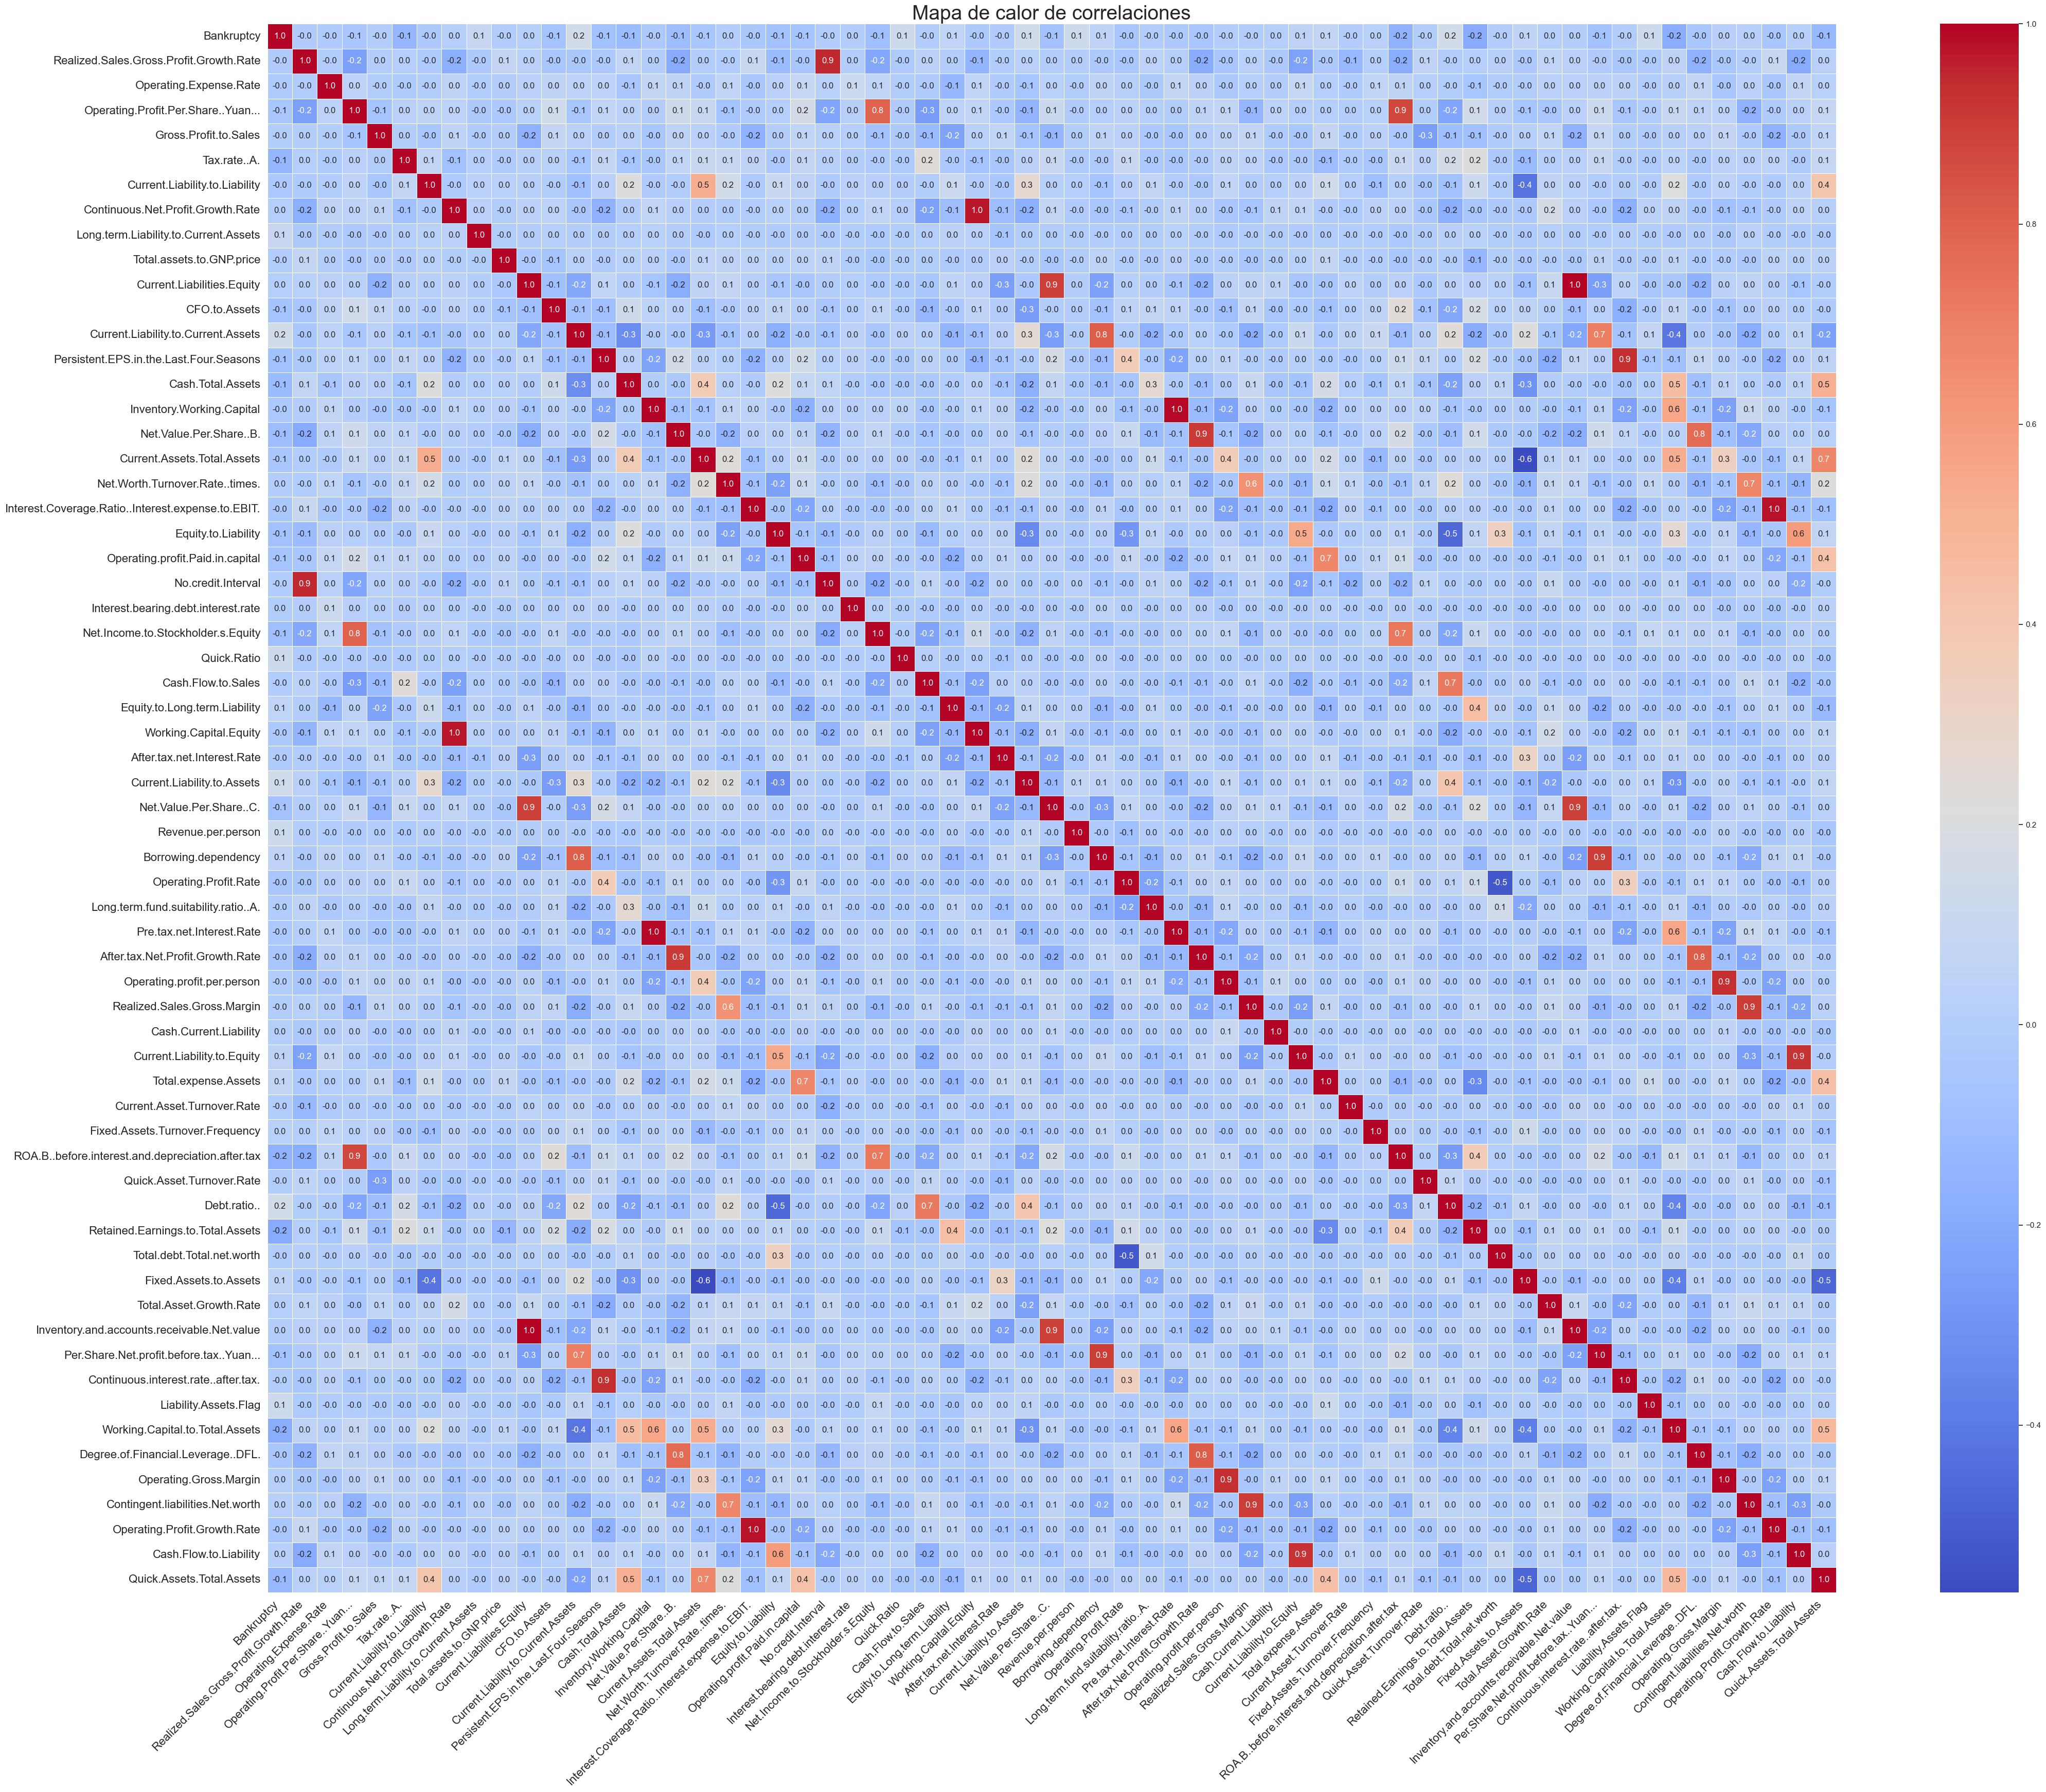

In [13]:
# Mapa de calor de correlaciones
plt.figure(figsize=(45, 35))
corr_matrix = train.drop(columns=['ID', 'Net.Income.Flag']).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".1f", cbar=True, 
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, 
            square=True, linewidths=0.5)

plt.xticks(rotation=45, ha="right", fontsize=16) 
plt.yticks(rotation=0, fontsize=16)
plt.title("Mapa de calor de correlaciones", fontsize=28)
plt.tight_layout()
plt.show()

Al analizar el mapa de calor de correlaciones se tienen los siguientes hallazgos:
1. **Correlaciones entre predictores**
  * Se observa que la mayoría de las correlaciones entre variables predictoras son bajas (valores entre -0.3 y 0.3), lo cual sugiere que la mayoría de las variables son relativamente independientes entre sí.

  * Algunos bloques de correlación más alta (cercana a ±0.6 o superior) indican relaciones más fuertes entre ciertos pares de variables, por ejemplo:

    * Variables relacionadas con liquidez (como Quick Assets/Total Assets, Cash/Current Liability, etc.) tienden a mostrar correlaciones más altas entre sí.

    * También se detectan algunas correlaciones moderadas entre variables relacionadas a rentabilidad y crecimiento de activos.

2. **Correlaciones con la variable objetivo (Bankruptcy)**
  * La variable Bankruptcy no muestra correlaciones fuertes con ningún predictor individual (en su mayoría menores a ±0.2). Esto implica que ninguna variable por sí sola puede predecir eficazmente la bancarrota, lo que sugiere calcular en la siguiente etapa nuevas variables para mejorar los predictores de la variable de interes. Además, refuerza la necesidad de modelos multivariados para capturar relaciones no lineales o combinaciones de predictores.

3. **Detección de posibles multicolinealidades**
  * Aunque en general las correlaciones no son extremadamente altas, hay algunos pares de variables con correlaciones superiores a 0.7 o menores a -0.7. Estos casos podrían potencialmente generar multicolinealidad si se usaran en modelos sensibles a la independencia de predictores (como regresión logística tradicional), lo sugiere la aplicación de técnicas de selección de variables, aunque en en modelos basados en redes neuronales o árboles, la multicolinealidad no es un problema crítico, es importante reconocer su existencia.


#### Correlaciones entre variables predictoras

Se identifican todos los pares de variables que tienen correlaciones mayores a 0.90:

In [14]:
# Matriz de correlación alta (superior a 0.90)
cor_matrix = train[variables_numericas].corr().abs()
alta_cor = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
pares_altamente_correlacionados = [(col, alta_cor[col].idxmax(), alta_cor[col].max()) 
                                   for col in alta_cor.columns if alta_cor[col].max() > 0.90]

print("Pares de variables altamente correlacionadas (> 0.90):")
for par in pares_altamente_correlacionados:
    print(f"{par[0]} y {par[1]} — Correlación: {par[2]:.2f}")


Pares de variables altamente correlacionadas (> 0.90):
No.credit.Interval y Realized.Sales.Gross.Profit.Growth.Rate — Correlación: 0.95
Working.Capital.Equity y Continuous.Net.Profit.Growth.Rate — Correlación: 0.97
Pre.tax.net.Interest.Rate y Inventory.Working.Capital — Correlación: 0.99
After.tax.Net.Profit.Growth.Rate y Net.Value.Per.Share..B. — Correlación: 0.91
Inventory.and.accounts.receivable.Net.value y Current.Liabilities.Equity — Correlación: 1.00
Continuous.interest.rate..after.tax. y Persistent.EPS.in.the.Last.Four.Seasons — Correlación: 0.93
Operating.Gross.Margin y Operating.profit.per.person — Correlación: 0.93
Operating.Profit.Growth.Rate y Interest.Coverage.Ratio..Interest.expense.to.EBIT. — Correlación: 0.98
Cash.Flow.to.Liability y Current.Liability.to.Equity — Correlación: 0.92


Algunos pares tienen correlación extremadamente alta e incluso perfecta como Inventory.and.accounts.receivable.Net.value y Current.Liabilities.Equity.

Se calculan y grafican las correlaciones más significativas con Bankruptcy.

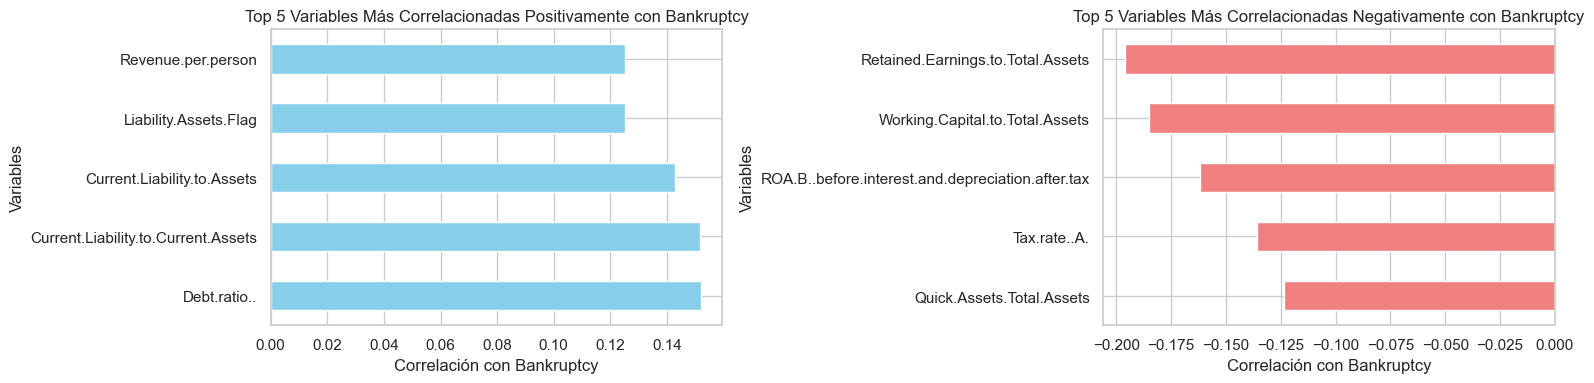

In [15]:
# Calcular la correlación con la variable 'Bankruptcy' y ordenar las variables
cor_target = train.corr()["Bankruptcy"].sort_values(ascending=False)
cor_target.drop(['ID', 'Bankruptcy', 'Net.Income.Flag'], inplace=True)

# Crear los subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # 1 fila, 2 columnas

# Subgráfico 1: Las 5 variables más correlacionadas positivamente con 'Bankruptcy'
cor_target.head(5).plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Top 5 Variables Más Correlacionadas Positivamente con Bankruptcy')
axes[0].set_xlabel('Correlación con Bankruptcy')
axes[0].set_ylabel('Variables')

# Subgráfico 2: Las 5 variables más correlacionadas negativamente con 'Bankruptcy'
cor_target.tail(5).plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('Top 5 Variables Más Correlacionadas Negativamente con Bankruptcy')
axes[1].set_xlabel('Correlación con Bankruptcy')
axes[1].set_ylabel('Variables')

plt.tight_layout()
plt.show()


* Las variables Revenue.per.person, Liability.Assets.Flag, Current.Liability.Assets, Current.Liability.Current.Assets y Debt.ratio son las que presentan una mayor correlación positiva con Bankruptcy. Sin embargo, los valores son relativamente bajos (alrededor de 0.12 a 0.15).
* Las variables Retained-Earnings.to.Total Assets, Working.Capital.to.Total.Assets, ROA.before.interest.and.depreciation.after.tax, Tax.rate.A, y Quick.Assets.Total.Assets presentan las mayores correlaciones negativas con Bankruptcy. Pero, al igual que el otro extremo, estas son de baja magnitud (alrededor de -0.12 a -0.20)


### **Conclusiones etapa 1: Exploración**
**Información general**
- El dataset de train contiene 2050 datos y 65 columnas (inclyyendo a la variable objetivo "Bankruptcy" de naturaleza binaria), mientras que el dataset de test contiene 500 datos y 64 columnas.
- 61 columnas son continuas, mientras que las variables ID, Net.Income.Flag y Liability.Assets.Flag son de tipo entero. Sin embargo, debido a la naturaleza del problema, la variable ID no tiene relevancia. Por otro lado, Net.Income.Flag solo toma el valor 1, lo que la convierte en una variable sin capacidad informativa significativa. Finalmente, la variable Liability.Assets.Flag es de tipo binario. Por lo anterior, ID y Net.Income.Flag se eliminaran en la etapa de preprocesamiento.
- No se identificaron valores nulos ni registros duplicados en el conjunto de datos, por lo que no es necesario realizar un preprocesamiento adicional.
- La variable objetivo está desbalanceada (La tasa de bancarrota es solo del 3%), por lo que se considera usar técnicas de balanceo en la siguiente etapa.
- Al aplicar el rango intercuartílico (IQR) se identificaron valores atípicos.

**Histogramas, estadísticas descriptivas y correlogramas**
- La mayoría de las variables presentan distribuciones asimétricas (sesgo positivo). Sin embargo, algunas variables muestran distribuciones relativamente centradas y acotadas, lo que sugiere que podrían haber sido normalizadas o estandarizadas cuando se calcularon. Esto se observa en los histogramas y estadísitas descriptivas.
- No todas las variables comparten la misma escala, lo que sugiere la necesidad de aplicar técnicas de normalización en la etapa de preparación de datos.
- Se observa que la mayoría de las correlaciones entre variables predictoras son bajas (valores entre -0.3 y 0.3), lo cual sugiere que la mayoría de las variables son relativamente independientes entre sí, sin embargo, se detectan algunas correlaciones moderadas entre variables relacionadas a rentabilidad y crecimiento de activos, y algunos pares tienen correlacione extremadamente altas e incluso perfecta.

**Justificación de uso de las variables**

El uso de estas variables contribuye a la solución del problema de predicción de bancarrota, ya que, además de su naturaleza y completitud, fueron calculadas directamente a partir de los estados financieros, los cuales reflejan objetivamente la posición de liquidez, el nivel de endeudamiento y la capacidad operativa de la empresa. Asimismo, el comportamiento financiero (como el nivel de pasivos, activos o ingresos por empleado) constituye uno de los principales determinantes reales de la probabilidad de insolvencia o bancarrota.

Sin embargo, dado que las correlaciones observadas entre las variables predictoras actuales y la variable de interés no resultaron ser significativamente fuertes, se evidencia que la ocurrencia de la quiebra depende de interacciones complejas entre múltiples factores y no de una única variable dominante. Esto resalta la necesidad de emplear modelos multivariados capaces de capturar relaciones no lineales y combinaciones de predictores. Además, en consecuencia, se propone el cálculo de nuevas variables basadas en bibliografía especializada, que podrían actuar como mejores predictores que las variables actualmente disponibles.

***
## 2. Preparación de los datos

En esta etapa, se aplican diversas técnicas de preprocesamiento para preparar los datos como insumo para el desarrollo de modelos predictivos.

### Ingeniería de variables
Considerando los resultados de la etapa anterior, el contexto de la predicción de bancarrota y basándonos en la revisión bibliográfica, a continuación, se crean nuevas variables que podrían ser mejores predictores que las existentes.

Estas variables incluyen ratios financieros, indicadores de solvencia y apalancamiento, además de medidas de eficiencia operativa y volatilidad.

- **Ratios financieros:**
(Z-score modificado de Altman, Capital de Trabajo sobre Activos Totales - Working Capital to Total Assets)
Son cálculos derivados de las principales cuentas financieras de la empresa, se utilizaron lo más usados en el análisis de bancarrota.

- **Indicadores de solvencia:**
(Apalancamiento extendido, Ratio de Solvencia - Equity to Liability, Stress Financiero - Pasivos Corrientes a Activos Líquidos) Miden la capacidad de una empresa para cumplir con sus obligaciones financieras a largo plazo, ya que una empresa con alta deuda es más susceptible a la bancarrota.

- **Eficiencia Operativa**
(Cambio en margen bruto vs margen operativo, Rentabilidad sobre ventas - Operating Profit Rate). Mide la habilidad de la empresa para utilizar sus recursos de manera eficiente para generar ganancias

- **Volatilidad:**
(Volatilidad del EPS - Earnings Per Share) Es una medida de la variabilidad o inestabilidad de las ganancias de una empresa a lo largo del tiempo

In [16]:
def extend_features(df): 
    # RATIOS FINANCIEROS
    # Z-score modificado de Altman
    df['Z_score_modificado'] = (
        1.2 * df['Working.Capital.to.Total.Assets'] +
        1.4 * df['Retained.Earnings.to.Total.Assets'] +
        3.3 * df['Operating.Profit.Rate'] +
        0.6 * df['Equity.to.Liability'] +
        1.0 * df['Revenue.per.person']  # Ajustado como proxy de ventas/activos
    )

    # Capital de trabajo neto sobre activos totales
    df['Capital_Trabajo_Ratio'] = (df['Current.Assets.Total.Assets'] - df['Current.Liability.to.Assets'])

    # INDICADORES DE SOLVENCIA
    # Apalancamiento extendido
    df['Apalancamiento_Extendido'] = df['Total.debt.Total.net.worth'] + df['Contingent.liabilities.Net.worth']

    # Ratio de cobertura de obligaciones financieras
    df['Cobertura_Deuda'] = df['Operating.Profit.Rate'] / (df['Interest.bearing.debt.interest.rate'] + 1e-6)

    # Indicador de estrés financiero: pasivos corrientes vs activos líquidos
    df['Stress_Financiero'] = df['Current.Liability.to.Current.Assets'] / (df['Cash.Total.Assets'] + 1e-6)

    # Relación de liquidez con obligaciones: flujo de caja vs pasivos
    df['Liquidez_vs_Pasivos'] = df['Cash.Flow.to.Liability'] - df['Interest.Coverage.Ratio..Interest.expense.to.EBIT.']

    # EFICIENCIA OPERATIVA
    # Cambio en margen bruto vs margen operativo (eficiencia operativa)
    df['Cambio_Margen_Bruto'] = df['Gross.Profit.to.Sales'] - df['Operating.Gross.Margin']

    # Bandera de alerta si flujo operativo es bajo y ratio de deuda alto
    df['Bandera_Bajo_Flujo_Operativo'] = np.where(
        (df['Cash.Flow.to.Sales'] < 0.05) & (df['Debt.ratio..'] > 0.7),
        1, 0) 

    # Margen de beneficio después de impuestos
    df['Margen_Neto_Post_Impuestos'] = df['After.tax.Net.Profit.Growth.Rate'] / (df['Operating.Profit.Rate'] + 1e-6)

    # VOLATILIDAD
    # Variación de utilidad por acción entre temporadas (estabilidad)
    df['Volatilidad_EPS'] = df['Persistent.EPS.in.the.Last.Four.Seasons'].rolling(window=4, min_periods=1).std()
    
    return df

In [17]:
# Agregar nuevas variables
train = extend_features(train)
test = extend_features(test)

#### Verificación de valores vacíos
Debido a la creación de nuevas variables, se verifica si quedaron valores vacíos.

In [18]:
# Porcentaje de valores nulos por columna dataset de train
nulls = train.isnull().mean().sort_values(ascending=False)
print(nulls[nulls > 0])

# Porcentaje de valores nulos por columna dataset de test
nulls = test.isnull().mean().sort_values(ascending=False)
print(nulls[nulls > 0])

Volatilidad_EPS    0.000488
dtype: float64
Volatilidad_EPS    0.002
dtype: float64


#### Imputación de valores vacíos: Median imputer

Para tratar los pocos valores vacios, se usa Median Imputer puesto que no introduce sesgos en la imputación, y a diferencia de la imputación con la media, que puede verse afectada por valores atípicos y distorsionar la distribución de los datos, la mediana es menos sensible a estos valores extremos. 

In [19]:
# Separar features y target para que al imputar tengan las mismas columnas
X = train.drop(columns=["Bankruptcy", "Net.Income.Flag", "ID"])
y = train["Bankruptcy"]

# Guardar ID del test para el submission
test_ids = test["ID"]
X_test = test.drop(columns=["Net.Income.Flag", "ID"])
X_test = X_test.reindex(columns=X.columns, fill_value=np.nan)

# Crear el imputer usando la mediana
median_imputer = SimpleImputer(strategy='median')

# Aplicar el imputer a los dataset de train y test
X_train_imputed = pd.DataFrame(median_imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(median_imputer.transform(X_test), columns=X.columns)

### División en datos de entrenamiento y validación

Se divide el set de train en entrenamiento y validación, asignando un porcentaje de 80% y 20%, respectivamente.

In [20]:
# Dividir dataset de train en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_imputed, y, test_size=0.2, stratify=y, random_state=42)

### Normalización de los datos

Se realiza normalización, ya que en redes neuronales es escencial, puesto que sin normalización, los algoritmos de optimización pueden tardar más en converger o incluso no converger debido a las diferencias en la magnitud de las variables.

In [21]:
# Escalar los datos
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_imputed)

### Balanceo: SMOTE

Dado el desbalanceo encontrado en la etapa de exploración, se plantea agregar el balanceo de datos con la técnica de SMOTE(Synthetic Minority Over-sampling Technique), dado que al generar ejemplos sintéticos de la clase minoritaria (Entró en quiebra), se aumenta su representación sin perder información, mejorando así la capacidad del modelo para identificar patrones relevantes en ambas clases y evitando el sobreajuste a la clase mayoritaria (No entró en quiebra).

In [22]:
# Aplicar SMOTE para balancear clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

### Selección de variables

Para la selección de variables se emplearan dos enfoques:

1. **Análisis de Componentes Principales (PCA):** Se utilizará PCA para reducir la dimensionalidad del conjunto de datos, identificando las combinaciones lineales más significativas de las variables.

2. **Importancia de las variables mediante XGBoost Classifier:** Se aplicará este potente algoritmo de árboles de decisión, para evaluar la importancia de cada variable en la predicción del objetivo. Este método utiliza el análisis de los "pesos o ganancias" obtenidos por cada característica en el proceso de entrenamiento para identificar cuáles son las variables que contribuyen más significativamente al rendimiento del modelo.

#### 1. Análisis de Componentes Principales (PCA)

In [23]:
# Inicializamos PCA
pca = PCA(n_components=0.97)

# Ajuste y transformación de los datos de entrenamiento
X_train_pca = pca.fit_transform(X_train_scaled)

# Transformación los datos de validación y prueba
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

#### 2. Importancia de las variables mediante XGBoost Classifier

In [24]:
def importance_XGBoost(X_train, y_train):
    # Entrenar el modelo
    xgb_model = XGBClassifier(random_state=42, tree_method="hist", device="cuda", eval_metric='logloss')
    xgb_model.fit(X_train, y_train)

    # Obtener la importancia por 'weight' o pesos
    feature_important = xgb_model.get_booster().get_score(importance_type='weight')

    # Extraer claves (f0, f1, etc) y valores
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    # Crear el DataFrame de importancia
    importance_df = pd.DataFrame({
        'feature_code': keys,
        'weight_importance': values
    })

    # Mapear de f0, f1, ... a los nombres reales de las columnas
    feature_map = {f"f{i}": col for i, col in enumerate(X.columns)}
    importance_df['feature_name'] = importance_df['feature_code'].map(feature_map)

    # Ordenar por importancia
    importance_df = importance_df.sort_values(by='weight_importance', ascending=False)

    return importance_df, xgb_model

In [25]:
importance_df, xgb_model = importance_XGBoost(X_train_scaled, y_train)
importance_df_bal, xgb_model_bal = importance_XGBoost(X_train_bal, y_train_bal)

In [26]:
# Filtrar las variables que superan el umbral de 5 de importancia -> Sin balanceo
threshold = 5
selected_features = importance_df[importance_df['weight_importance'] > threshold]['feature_name'].tolist()
print(f"Número de variables seleccionadas sin SMOTE: {len(selected_features)}")

Número de variables seleccionadas sin SMOTE: 40


In [27]:
# Filtrar las variables que superan el umbral de 9 de importancia -> Con balanceo
threshold_bal = 9
selected_features_bal = importance_df_bal[importance_df_bal['weight_importance'] > threshold_bal]['feature_name'].tolist()
print(f"Número de variables seleccionadas con SMOTE {len(selected_features_bal)}")

Número de variables seleccionadas con SMOTE 42


### Obtención de datasets para desarrollo de modelos

Dado que algunos algoritmos pueden manejar eficientemente conjuntos de datos desbalanceados, se generaron cuatro datasets, que son el resultado de aplicar una de las dos técnicas de selección de variables y de utilizar o no la técnica de balanceo SMOTE. A continuación, se presentan:
1. Dataset de selección de variables XGBOOST sin balanceo
2. Dataset de selección de variables XGBOOST con balanceo (SMOTE)
3. Dataset de selección de variables PCA sin balanceo
4. Dataset de selección de variables PCA con balanceo (SMOTE)

#### 1. Obtención dataset de selección de variables XGBOOST sin balanceo

In [28]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train_imputed.columns)

# Subconjunto de datos con esas variables
X_train_sub = X_train_scaled_df[selected_features]
X_valid_sub = X_val_scaled_df[selected_features]

#### 2. Obtención dataset de selección de variables XGBOOST con balanceo (SMOTE)

In [29]:
X_train_scaled_df_bal = pd.DataFrame(X_train_bal, columns=X_train_imputed.columns)
X_val_scaled_df_bal = pd.DataFrame(X_val_scaled, columns=X_train_imputed.columns)

# Subconjunto de datos con esas variables
X_train_sub_bal = X_train_scaled_df_bal[selected_features_bal]
X_valid_sub_bal = X_val_scaled_df_bal[selected_features_bal]

# y_train_bal

#### 3. Obtención dataset de selección de variables PCA sin balanceo

In [30]:
# X_train_pca
# X_val_pca

#### 4. Obtención dataset de selección de variables PCA con balanceo (SMOTE)

In [31]:
X_train_pca_bal, y_train_bal = smote.fit_resample(X_train_pca, y_train)
# X_val_pca

### **Conclusiones etapa 2: Preparación de los datos**

- Como parte de la ingeniería de variables y basándonos en la bibliografía revisada, se crearon 10 nuevas variables que podrían mejorar la capacidad predictiva del modelo para identificar empresas en riesgo de bancarrota. No obstante, para mitigar los efectos de la multicolinealidad, se implementaron dos estrategias de selección de variables:

    - Análisis de Componentes Principales (PCA): Se seleccionaron los componentes principales que explican el 97% de la varianza.

    - Importancia de variables en XGBoost: Se emplearon los pesos o ganancias derivados del modelo XGBoost para identificar las variables con mayor aporte al desempeño del modelo.

    En ambos casos, se realizaron pruebas adicionales para definir los umbrales de selección óptimos, considerando también la aplicación de la técnica SMOTE para el balanceo de clases.

- Para el desarrollo de las siguientes etapas, el conjunto de entrenamiento fue dividido en entrenamiento y validación con una proporción 80% y 20%, respectivamente.

- Dado el desbalanceo de clases identificado durante la exploración de los datos, se aplicó la técnica de oversampling mediante SMOTE con el objetivo de evaluar su impacto en el rendimiento de los modelos.

- Como resultado de este proceso, se obtuvieron cuatro datasets diferentes:

    - Dataset con selección de variables por XGBoost, sin balanceo.
    - Dataset con selección de variables por XGBoost, con balanceo (SMOTE).
    - Dataset con selección de variables por PCA, sin balanceo.
    - Dataset con selección de variables por PCA, con balanceo (SMOTE).



***
## 3. Análisis preliminar de selección de modelos

En esta etapa se analizan distintos modelos predictivos candidatos para abordar el problema de predicción de bancarrota.

Dado que en las variables originales no se identificaron correlaciones fuertes entre las variables predictoras y la variable objetivo, se descartan enfoques univariables y modelos puramente lineales, los cuales asumirían una relación lineal fuerte entre los predictores y la respuesta. Además, se consideran los cuatro conjuntos de datos disponibles: dos sin técnicas de balanceo aplicadas y dos balanceados mediante la estrategia de oversampling SMOTE.

Por lo anterior se proponen los siguientes tipos de modelos:

- **XGBoost**: Es un algoritmo basado en el método de gradient boosting, donde los árboles sucesivos corrigen los errores de los anteriores minimizando una función de pérdida regularizada, y es altamente eficiente para datos tabulares como es el caso. Es particularmente adecuado para problemas de desbalanceo al permitir el ajuste del parámetro scale_pos_weight, además de capturar interacciones no lineales complejas entre las variables. Sin embargo, es muy sensible a la selección de hiperparámetros como el learning_rate, max_depth y el número de estimators, por lo que se debe calibrar muy bien estos hiperparámetros.

- **Random Forest Classifier:** Es un algoritmo de bagging que construye múltiples árboles de decisión independientes entrenados sobre subconjuntos aleatorios del dataset, y combina sus predicciones mediante votación. Presenta una alta robustez frente a ruido en los datos y a overfitting, además de soportar ponderaciones de clases (class_weight), lo cual es ventajoso para tratar los datasets desbalanceados.

- **Support Vector Machine (SVM):** Es un algoritmo que busca el hiperplano que maximiza el margen entre clases. Es robusto ante la presencia de outliers (identificados en la etapa de exploración). Es sensible a la escala de los datos, lo cual está solucionado ya que los 4 datasets están normalizados. Aunque es costoso computacionalmente, puede ser fuerte en problemas desbalanceados si se ajustan adecuadamente los hiperparametros. 

- **Redes Neuronales MLP (Multi-Layer Perceptron):** Puede presetar desempeños óptimos al ser capaz de capturar patrones altamente no lineales y combinaciones de múltiples variables, además al incluirse mecanismos de regularización como dropout, early stopping y penalización L2 se puede mejorar la generalización y es adaptable a problemas de desbalance a través de la ponderación de la función de pérdida.

Adicionalmente, se plantea usar varias métricas de evaluación como:
- ROC-AUC: Captura la capacidad discriminativa del modelo entre clases.
- Recall: Detecta la proporción de verdaderos positivos correctamente identificados sobre el total de positivos reales. Es importante en este escenario donde los falsos negativos (no detectar una bancarrota) tienen un alto costo.
- Precisión: Mide la proporción de verdaderos positivos sobre todas las predicciones positivas realizadas. Resulta importante para minimizar los falsos positivos, es decir, evitar señalar erróneamente empresas solventes como próximas a la quiebra.
- F1-Score: Equilibrio entre Precision y Recall, especialmente crítico en los datasets desbalanceados.
Se seleccionan estas métricas debido a que, en el contexto de predicción de bancarrotas, el impacto de un falso negativo (no identificar una empresa que efectivamente quebrará) es significativamente más severo que el de un falso positivo (advertir una quiebra que no se materializa).

Por otra parte, debido a los requerimientos del caso en las siguientes etapas solo se consideran Redes Neuronales MLP (Multi-Layer Perceptron).


***
## 4. Desarrollo y calibración de modelos

Debido a los requerimientos del proyecto, únicamente se permite el uso de redes neuronales tipo MLP (Perceptrón Multicapa). Por tanto, en esta sección se procede a la calibración de este tipo de modelos.

### Diseño de la arquitectura de la red MLP y compilación del modelo: Modelo base

Previamente se realizaron diversas pruebas exploratorias para determinar la arquitectura más adecuada de la red neuronal MLP. Los resultados mostraron que los modelos con menos capas ocultas tendían a tener mejor desempeño, probablemente debido a la cantidad moderada de datos (se disminuyó con las división de train y validación) y la disminución del número de variables predictivas.

A continuación, se define un modelo base de red neuronal compuesta por 2 capas ocultas con 64 y 32 neuronas respectivamente (balance entre representación y simplicidad), utilizando la función de activación ReLU (mitigar problema de desvanecimiento deel gradiente). La capa de salida es de una sola neurona con activación sigmoide, dado que se trata de un problema de clasificación binaria. El modelo se compiló con el optimizador Adam por su capacidad de adaptarse a los parámetros de entrenamiento, función de pérdida binary crossentropy y exactitud y auc como métrica de evaluación.

In [32]:
def plot_training_history(history):
    # Graficar la pérdida (Loss)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Evolución de la función de pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Graficar el AUC
    plt.subplot(1,2,2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Evolución del AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [41]:
def evaluacion_modelo(history):
    # Extraer las métricas de history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_precision = history.history['precision']
    val_precision = history.history['val_precision']
    train_recall = history.history['recall']
    val_recall = history.history['val_recall']
    train_auc = history.history['auc']
    val_auc = history.history['val_auc']
    
    # Función para calcular F1-score a partir de Precision y Recall
    def calcular_f1(precision, recall):
        if (precision + recall) != 0:
            return 2 * (precision * recall) / (precision + recall)
        return 0  # Si Precision + Recall es 0, devolver 0 (o usar otro valor según lo que prefieras)

    # Usamos el último valor (última época) de cada métrica para el cálculo del F1-score
    f1_train = calcular_f1(train_precision[-1], train_recall[-1])
    f1_val = calcular_f1(val_precision[-1], val_recall[-1])

    # Crear df con resultados
    metrics_data = {
        'Train': [train_loss[-1], train_accuracy[-1], train_precision[-1], train_recall[-1], train_auc[-1], f1_train],
        'Validation': [val_loss[-1], val_accuracy[-1], val_precision[-1], val_recall[-1], val_auc[-1], f1_val]
    }
    
    df_metrics = pd.DataFrame(metrics_data, index=['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC', 'F1-score'])
    df_metrics = df_metrics.round(2)
    
    return df_metrics, val_loss[-1], val_auc[-1], val_precision[-1], val_recall[-1], f1_val


In [52]:
# Definir modelo base
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

history = model.fit(
    X_train_sub, y_train,
    validation_data=(X_valid_sub, y_val),
    epochs=50, 
    batch_size=32,
    verbose=0
)

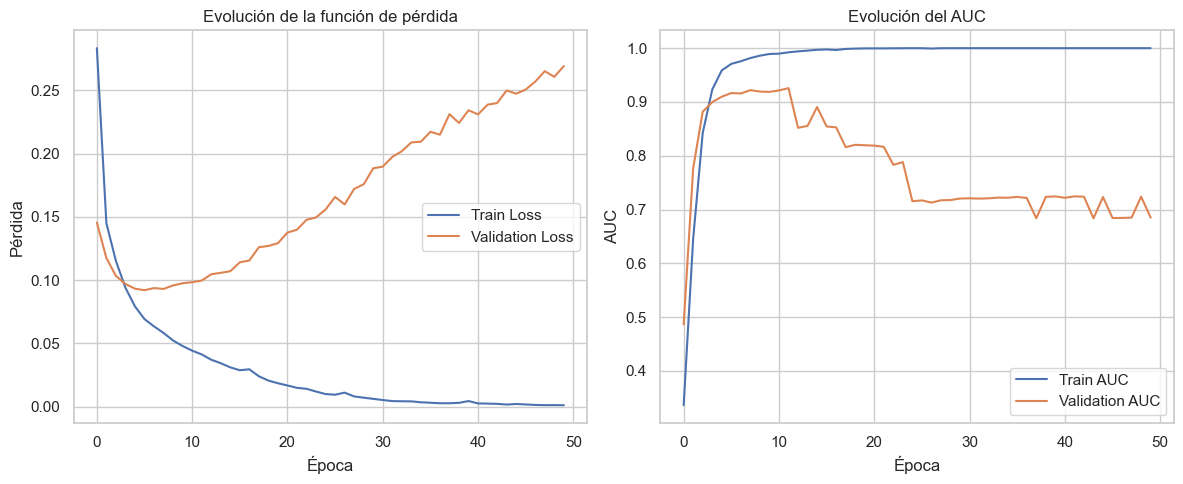

0.2691952586174011 0.685092031955719 0.375 0.25 0.3


Train  Validation
Loss         0.0        0.27
Accuracy     1.0        0.97
Precision    1.0        0.38
Recall       1.0        0.25
AUC          1.0        0.69
F1-score     1.0        0.30

In [53]:
plot_training_history(history)
df_metrics_base, val_loss_base, val_auc_base, val_precision_base, val_recall_base, f1_val_base = evaluacion_modelo(history)
print(val_loss_base, val_auc_base, val_precision_base, val_recall_base, f1_val_base)
df_metrics_base

Tanto en las gráficas de evolución como en las métricas de evaluación, se observa que el modelo está experimentando overfitting. A pesar de que el modelo tiene un desempeño perfecto en el conjunto de entrenamiento, con un F1-score y un AUC de 1, su rendimiento en el conjunto de validación es significativamente más bajo.

Esto sugiere la incorporación de técnicas de regularización y el ajuste de los hiperparámetros.

### Modelo base + Incorporación de técnicas de regularización

In [54]:
# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],), 
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

history = model.fit(
    X_train_sub, y_train,
    validation_data=(X_valid_sub, y_val),
    epochs=50, 
    batch_size=32,
    verbose=0
)

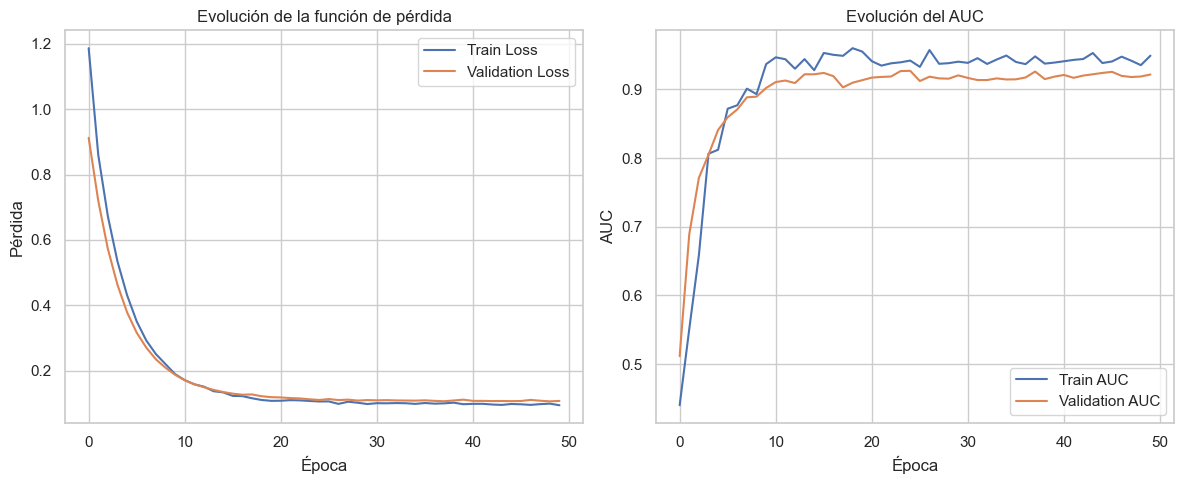

0.10754568874835968 0.9216917157173157 0.5 0.0833333358168602 0.1428571465064068


Train  Validation
Loss        0.09        0.11
Accuracy    0.98        0.97
Precision   1.00        0.50
Recall      0.22        0.08
AUC         0.95        0.92
F1-score    0.36        0.14

In [55]:
plot_training_history(history)
df_metrics_base_reg, val_loss_base_reg, val_auc_base_reg, val_precision_base_reg, val_recall_base_reg, f1_val_base_reg = evaluacion_modelo(history)
print(val_loss_base_reg, val_auc_base_reg, val_precision_base_reg, val_recall_base_reg, f1_val_base_reg)
df_metrics_base_reg

Con la incorporación de técnicas de regularización, como Dropout y regularización L2, el nuevo modelo muestra una mejora respecto al modelo base, ya que se logró controlar el overfitting. Sin embargo, aún existen áreas de oportunidad para optimizar el rendimiento. Aunque el desempeño es consistente entre el conjunto de entrenamiento y el de validación, ambos resultados siguen siendo relativamente bajos. Por lo tanto, el siguiente paso es realizar ajustes en los hiperparámetros para mejorar aún más la capacidad de generalización del modelo.

### Calibración de hiperparámetros manual

Inicialmente, se llevó a cabo un ajuste manual de los hiperparámetros con el objetivo de comprender mejor la evolución de las métricas de la red neuronal. Durante este proceso, se variaron parámetros clave como el número de neuronas, la función de activación, la tasa de regularización para todas las capas, el dropout, la tasa de aprendizaje, el optimizador y el número de épocas. A continuación, se presentan algunas de las pruebas realizadas.

![Imagen](https://github.com/ikteran/Proyecto_Bancarrota_DeepLearning/raw/49f8710bf60c6bd7c6dae5eaf4d21177a4bca7c5/results/resultados_calibracion_manual.png)


El mejor modelo es el resaltado en verde y se presenta a continuación:

#### Mejor modelo ajuste de hiperparámetros manual

In [56]:
# Mejor modelo con ajuste de hiperparámetros manual
model_manual= models.Sequential([
    layers.Dense(40, activation='gelu', input_shape=(X_train_sub.shape[1],),
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.8),
    layers.Dense(20, activation='silu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    layers.Dropout(0.8),
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model_manual.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

history_manual = model_manual.fit(
    X_train_sub, y_train,
    validation_data=(X_valid_sub, y_val),
    epochs=100, 
    batch_size=32,
    verbose=0
)

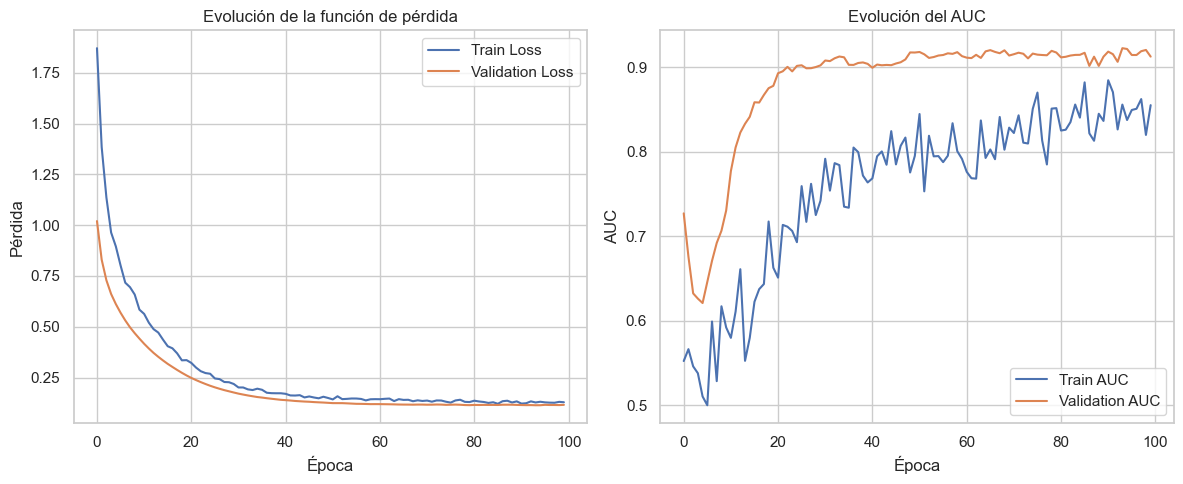

0.11583803594112396 0.9125838279724121 0.0 0.0 0


Train  Validation
Loss        0.13        0.12
Accuracy    0.97        0.97
Precision   0.25        0.00
Recall      0.02        0.00
AUC         0.86        0.91
F1-score    0.04        0.00

In [57]:
plot_training_history(history_manual)
df_metrics_man, val_loss_man, val_auc_man, val_precision_man, val_recall_man, f1_val_man = evaluacion_modelo(history_manual)
print(val_loss_man, val_auc_man, val_precision_man, val_recall_man, f1_val_man)
df_metrics_man

Al analizar las curvas de entrenamiento y validación en función de la evolución de la función de pérdida, se observa una disminución sostenida seguida de una estabilización a medida que aumenta el número de épocas en ambos conjuntos de datos. 

Respecto a la evolución del AUC, aunque el AUC del conjunto de entrenamiento presenta algo de variabilidad, el AUC del conjunto de validación se estabiliza rápidamente en valores elevados (0.92), superando al AUC de entrenamiento. Esto sugiere que no hay un sobreajuste significativo y que el modelo no solo aprende correctamente, sino que también generaliza bien en el conjunto de validación.

El F1-score bajo en validación indica que, aunque el modelo puede distinguir entre las clases en términos generales (lo que se refleja en un AUC más alto), no está identificando bien las instancias positivas en términos de precisión y recall. 

### Calibración de hiperparámetros en Keras

Para la calibración de hiperparámetros en Keras, se utilizan dos enfoques:
1. **Randomized Search:** Consiste en la búsqueda de hiperparámetros de forma aleatoria dentro de un espacio definido de valores

2. **Grid search:** Es un enfoque de búsqueda exhaustiva donde se prueban todas las combinaciones posibles de hiperparámetros dentro de un espacio definido.

3. **Keras turner:** Es una herramienta eficiente para encontrar los mejores hiperparámetros. Funciona utilizando métodos de optimización de hiperparámetros más sofisticados que los anteriores enfoques. En lugar de realizar una búsqueda exhaustiva o aleatoria en un espacio de parámetros, Keras Tuner emplea algoritmos más avanzados, como Bayesian Optimization.

Por lo que se presenta la función que compila el modelo completo, la clase keras classifier para poder emplear los dos primeros enfoques, y el diccionario de hiperparámetros que emplearan.


In [58]:
# Definir la función de construcción del modelo
def build_keras_base(hidden_layers=[40, 20], dropout_rate=0.8, optimizer='adam', learning_rate=0.001):
#def build_keras_base(hidden_layers=[40, 20], dropout_rate=0.8, optimizer='adam', learning_rate=0.001):
    model_opt = models.Sequential()

    # Primera capa densa con regularización L2
    model_opt.add(layers.Dense(hidden_layers[0], activation='gelu', input_shape=(X_train_sub.shape[1],),
                               kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model_opt.add(layers.Dropout(dropout_rate))

    # Segunda capa densa con regularización L2
    model_opt.add(layers.Dense(hidden_layers[1], activation='silu', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.005)))
    model_opt.add(layers.Dropout(dropout_rate))

    # Capa de salida con activación sigmoide
    model_opt.add(layers.Dense(1, activation='sigmoid'))

    # Crear el optimizador basado en el nombre pasado
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer_instance = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        optimizer_instance = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        optimizer_instance = Nadam(learning_rate=learning_rate)
    elif optimizer == 'ftrl':
        optimizer_instance = Ftrl(learning_rate=learning_rate)
    else:
        raise ValueError(f"Optimizer {optimizer} no reconocido.")

    # Compilación del modelo
    model_opt.compile(optimizer=optimizer_instance,
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

    return model_opt


In [59]:
# Configurar el KerasClassifier
model_keras = KerasClassifier(build_fn=build_keras_base, verbose=0)
model_keras._estimator_type = "classifier"

In [60]:
# Parámetros para la búsqueda de hiperparámetros
hidden_layers_opt = [[40, 20], [40, 15], [50, 25]]
batch_size_opt = [16, 32]
epochs_opt = [30, 60, 100, 120]
optimizer = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'nadam', 'ftrl']
learning_rate_opt = [0.001, 0.01, 0.1]

parameters_opt = {
    'hidden_layers': hidden_layers_opt,
    'optimizer': optimizer,
    'batch_size': batch_size_opt,
    'epochs': epochs_opt,
    'learning_rate': learning_rate_opt
}

#### 1. Randomized search

A continuación se plantea una búsqueda aleatoria con validación cruzada, con el objetivo de encontrar la combinación de parámetros que maximice el AUC en los datos de validación.

In [61]:
rnd_search = RandomizedSearchCV(model_keras,
                                param_distributions=parameters_opt, 
                                scoring='roc_auc',
                                n_iter=10,
                                cv=10,
                                verbose=1)

In [48]:
# Realizar la búsqueda
rnd_result = rnd_search.fit(X_train_sub, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [49]:
# Mejor modelo con ajuste de hiperparámetros randomized search
best_model = rnd_search.best_estimator_

best_params = rnd_search.best_params_
print("Mejores parámetros encontrados:", best_params)

Mejores parámetros encontrados: {'optimizer': 'nadam', 'learning_rate': 0.001, 'hidden_layers': [50, 25], 'epochs': 100, 'batch_size': 16}


In [62]:
# Ejecución del mejor modelo con ajuste de hiperparámetros randomized search
model_rnd= models.Sequential([
    layers.Dense(50, activation='gelu', input_shape=(X_train_sub.shape[1],),
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.8),
    layers.Dense(25, activation='silu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    layers.Dropout(0.8),
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model_rnd.compile(optimizer=Nadam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

history_rnd = model_rnd.fit(
    X_train_sub, y_train,
    validation_data=(X_valid_sub, y_val),
    epochs=100, 
    batch_size=16,
    verbose=0
)

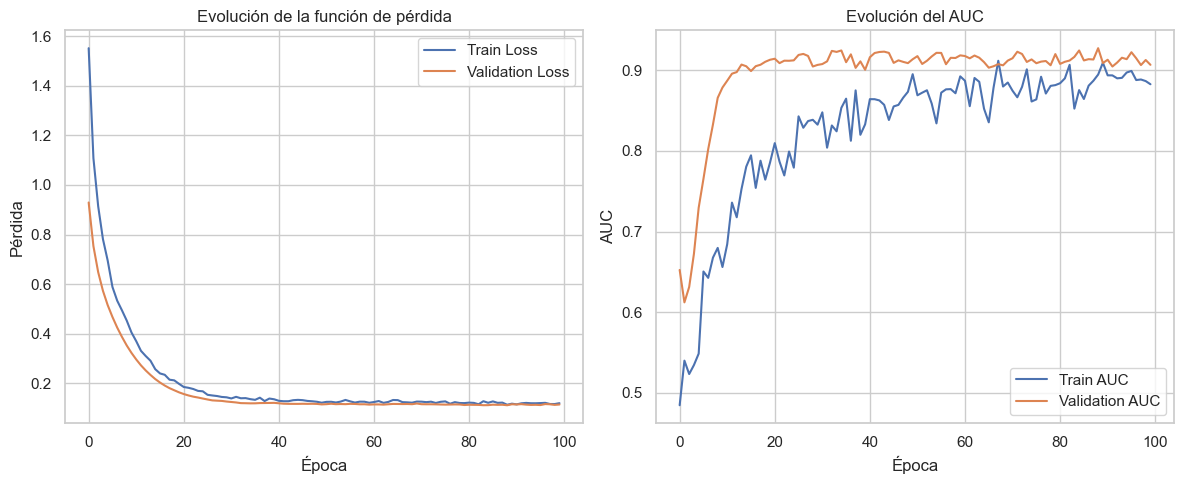

0.11519674211740494 0.9068257808685303 0.0 0.0 0


Train  Validation
Loss        0.12        0.12
Accuracy    0.97        0.97
Precision   0.71        0.00
Recall      0.10        0.00
AUC         0.88        0.91
F1-score    0.18        0.00

In [63]:
# Evaluación del mejor modelo con ajuste de hiperparámetros randomized search
plot_training_history(history_rnd)
df_metrics_rnd, val_loss_rnd, val_auc_rnd, val_precision_rnd, val_recall_rnd, f1_val_rnd = evaluacion_modelo(history_rnd)
print(val_loss_rnd, val_auc_rnd, val_precision_rnd, val_recall_rnd, f1_val_rnd)
df_metrics_rnd

El desempeño de este modelo es favorable, donde los valores de la función de pérdida son similares a los obtenidos con el modelo de calibración de hiperparámetros manual, al igual que el accuracy. 

La evolución de la función de pérdida es adecuada, sin indicios de overfitting, lo que refleja una buena generalización del modelo. 

Similar al modelo anterior, la curva de AUC en el conjunto de entrenamiento presenta más ruido que en el de validación, aunque ambos alcanzan altos valores, lo que indica una sólida capacidad discriminativa. 

En cuanto al F1-Score, se observa una mejora en el conjunto de entrenamiento en comparación con el modelo previo, aunque el valor de validación permanece igual en ambos modelos.

#### 2. Grid search

In [ ]:
# Búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=model_keras, 
                           param_grid=parameters_opt,
                           cv=5,
                           verbose=2)

# Realizamos la búsqueda de los mejores hiperparámetros
grid_search_result = grid_search.fit(X_train_sub, y_train)

# Mostramos los mejores resultados
print(f"Mejores parámetros: {grid_search_result.best_params_}")
print(f"Mejor puntuación: {grid_search_result.best_score_}")


Fitting 5 folds for each of 504 candidates, totalling 2520 fits
[CV] END batch_size=16, epochs=30, hidden_layers=[40, 20], learning_rate=0.001, optimizer=adam; total time=   4.5s
[CV] END batch_size=16, epochs=30, hidden_layers=[40, 20], learning_rate=0.001, optimizer=adam; total time=   4.4s
[CV] END batch_size=16, epochs=30, hidden_layers=[40, 20], learning_rate=0.001, optimizer=adam; total time=   4.3s
[CV] END batch_size=16, epochs=30, hidden_layers=[40, 20], learning_rate=0.001, optimizer=adam; total time=   4.4s
[CV] END batch_size=16, epochs=30, hidden_layers=[40, 20], learning_rate=0.001, optimizer=adam; total time=   4.8s
[CV] END batch_size=16, epochs=30, hidden_layers=[40, 20], learning_rate=0.001, optimizer=sgd; total time=   4.1s
[CV] END batch_size=16, epochs=30, hidden_layers=[40, 20], learning_rate=0.001, optimizer=sgd; total time=   4.1s
[CV] END batch_size=16, epochs=30, hidden_layers=[40, 20], learning_rate=0.001, optimizer=sgd; total time=   4.1s
[CV] END batch_size

In [203]:
print(f"Mejores parámetros: {grid_search_result.best_params_}")
print(f"Mejor puntuación: {grid_search_result.best_score_}")

Mejores parámetros: {'batch_size': 16, 'epochs': 100, 'hidden_layers': [50, 25], 'learning_rate': 0.1, 'optimizer': 'adagrad'}
Mejor puntuación: 0.9713414907455444


In [64]:
# Mejor modelo con ajuste de hiperparámetros Grid Search
model_best_GS = build_keras_base(hidden_layers=[50, 25],
    dropout_rate=0.8,
    optimizer='adagrad',
    learning_rate=0.1
)


# Entrenar el modelo y capturar el history
history_GS = model_best_GS.fit(X_train_sub, y_train,
                         batch_size=16,
                         epochs=100,
                         verbose=0,
                         validation_data=(X_valid_sub, y_val))

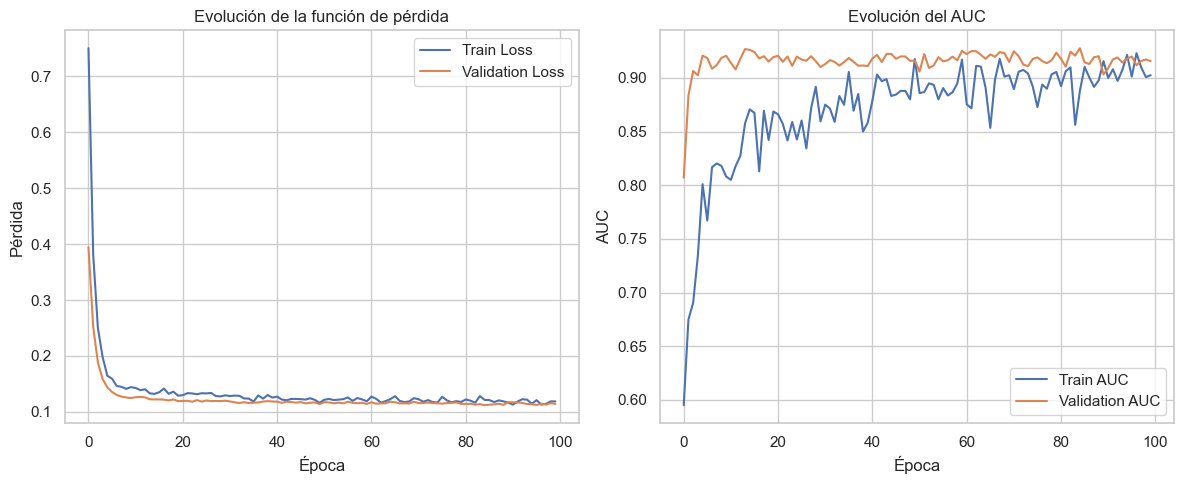

0.11414438486099243 0.915724515914917 0.0 0.0 0


Train  Validation
Loss        0.12        0.11
Accuracy    0.97        0.97
Precision   0.50        0.00
Recall      0.04        0.00
AUC         0.90        0.92
F1-score    0.07        0.00

In [65]:
# Evaluación del mejor modelo con ajuste de hiperparámetros Grid Search
plot_training_history(history_GS)
df_metrics_GS, val_loss_GS, val_auc_GS, val_precision_GS, val_recall_GS, f1_val_GS = evaluacion_modelo(history_GS)
print(val_loss_GS, val_auc_GS, val_precision_GS, val_recall_GS, f1_val_GS)
df_metrics_GS

El desempeño del modelo obtenido a través de la calibración de hiperparámetros con Grid Search es prometedor, ya que la curva de la función de pérdida muestra una disminución y estabilización rápida tanto en el conjunto de entrenamiento como en el de validación. En lo que respecta a la evolución del AUC, se observa cierta fluctuación, especialmente en el conjunto de entrenamiento, donde el ruido es más pronunciado. Sin embargo, ambos conjuntos alcanzan valores de AUC elevados, lo que indica un buen desempeño del modelo en términos de su capacidad discriminativa.

Sin embargo, una gran desventaja que se comprobó de este método es el tiempo que tarda en realizar la búsqueda de los hiperparámetros óptimos. Dado que Grid Search evalúa todas las combinaciones posibles de los parámetros definidos, el proceso fue muy lento.

#### 3. Keras turner

Al igual que en los enfoques anteriores, primero se debe crear la función de construcción del modelo (definida a continuación). En este caso, la variación de los parámetros se definen dentro de la función.  Además, se implementa el callback EarlyStopping para optimizar el tiempo de entrenamiento al detener el proceso cuando no se detectan mejoras en el rendimiento.

Dado que los modelos anteriores mostraron bajos valores en el F1-Score, y aunque las redes neuronales pueden manejar de manera eficiente conjuntos de datos desbalanceados, se procede a calibrar los hiperparámetros utilizando los cuatro conjuntos de datos diferentes para evaluar si mejora o no el desempeño:

1. Dataset de selección de variables XGBOOST sin balanceo (Usado en todos los modelos previos) --> D1
2. Dataset de selección de variables XGBOOST con balanceo (SMOTE) --> D2
3. Dataset de selección de variables PCA sin balanceo --> D3
4. Dataset de selección de variables PCA con balanceo (SMOTE) --> D4

In [34]:
# Definir el EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)

In [36]:
def busqueda_hiperparams_tuner(X_train, y_train, X_val, y_val):
    # Función para construir el modelo
    def build_keras_base(hp):
        model_opt = models.Sequential()

        # Primera capa densa con regularización L2
        model_opt.add(layers.Dense(
            hp.Int('units_1', min_value=16, max_value=64, step=16),
            activation='gelu',
            input_shape=(X_train.shape[1],),
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        model_opt.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.9, step=0.1)))

        # Segunda capa densa
        model_opt.add(layers.Dense(
            hp.Int('units_2', min_value=16, max_value=64, step=16),
            activation='silu',
            kernel_regularizer=tf.keras.regularizers.l2(0.005)
        ))
        model_opt.add(layers.Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.9, step=0.1)))

        # Capa de salida
        model_opt.add(layers.Dense(1, activation='sigmoid'))

        # Seleccionar el optimizador
        optimizer_choice = hp.Choice('optimizer', values=['adam', 'adagrad', 'adadelta', 'nadam', 'ftrl'])

        if optimizer_choice == 'adam':
            optimizer_instance = Adam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
        elif optimizer_choice == 'adagrad':
            optimizer_instance = Adagrad(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
        elif optimizer_choice == 'adadelta':
            optimizer_instance = Adadelta(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
        elif optimizer_choice == 'nadam':
            optimizer_instance = Nadam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
        elif optimizer_choice == 'ftrl':
            optimizer_instance = Ftrl(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))

        # Compilar el modelo
        model_opt.compile(optimizer=optimizer_instance,
                          loss='binary_crossentropy',
                          metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
        
        return model_opt

    # Configuración del tuner
    directory = os.path.abspath('kt_dir')
    project_name = 'model_tuning'
    path_to_delete = os.path.join(directory, project_name)
    if os.path.exists(path_to_delete):
        shutil.rmtree(path_to_delete)

    tuner = kt.Hyperband(
        build_keras_base,
        objective='val_loss',
        max_epochs=40,
        factor=3,
        directory=directory,
        project_name=project_name
    )

    # Búsqueda de hiperparámetros
    tuner.search(X_train, y_train, epochs=40, validation_data=(X_val, y_val))

    # Obtener los mejores hiperparámetros
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Mejores hiperparámetros encontrados: {best_hyperparameters.values}")

    # Construir y entrenar el mejor modelo
    best_model_tuner = tuner.hypermodel.build(best_hyperparameters)
    history_tuner = best_model_tuner.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))

    return best_model_tuner, history_tuner

##### 3.1 Entrenamiento con dataset de selección de variables XGBOOST sin balanceo

In [47]:
best_model_tuner_D1, history_turner_D1 = busqueda_hiperparams_tuner(X_train_sub, y_train, X_valid_sub, y_val)

Trial 90 Complete [00h 00m 08s]
val_loss: 1.2301617860794067

Best val_loss So Far: 0.10076415538787842
Total elapsed time: 00h 04m 49s
Mejores hiperparámetros encontrados: {'units_1': 16, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0024335509762462414, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0076'}
Epoch 1/40
52/52 [==============================] - 2s 11ms/step - loss: 0.7395 - accuracy: 0.8726 - precision: 0.0182 - recall: 0.0600 - auc: 0.3896 - val_loss: 0.4756 - val_accuracy: 0.9707 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5567
Epoch 2/40
52/52 [==============================] - 0s 2ms/step - loss: 0.4125 - accuracy: 0.9689 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6179 - val_loss: 0.3191 - val_accuracy: 0.9707 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7648
Epoch 3/40
52/52 [==============================] - 0s 

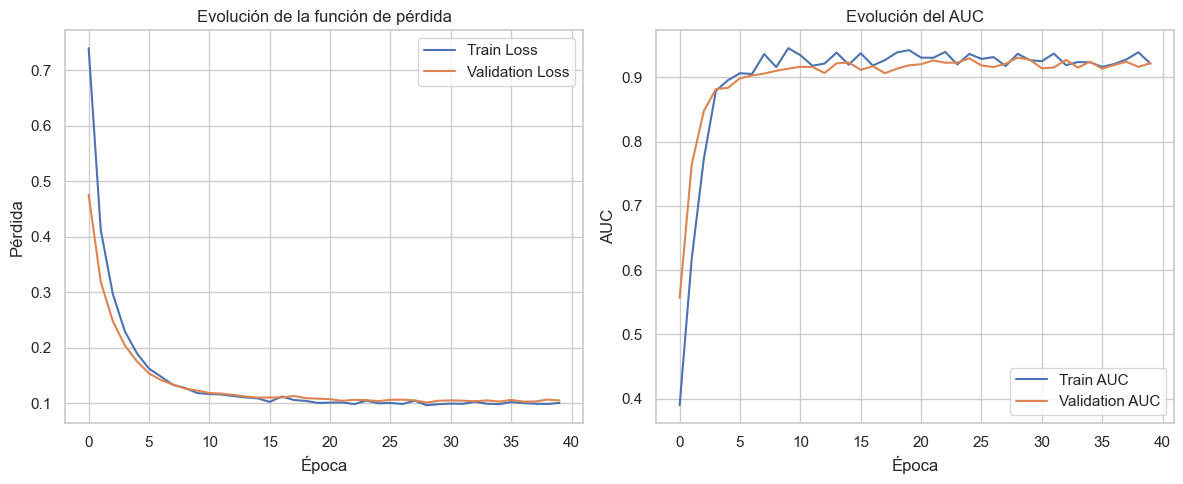

0.1055237203836441 0.9220058917999268 0.0 0.0 0


Train  Validation
Loss        0.10        0.11
Accuracy    0.97        0.97
Precision   0.82        0.00
Recall      0.18        0.00
AUC         0.92        0.92
F1-score    0.30        0.00

In [48]:
plot_training_history(history_turner_D1)
df_metrics_D1, val_loss_D1, val_auc_D1, val_precision_D1, val_recall_D1, f1_val_D1 = evaluacion_modelo(history_turner_D1)
print(val_loss_D1, val_auc_D1, val_precision_D1, val_recall_D1, f1_val_D1)
df_metrics_D1

##### 3.2 Entrenamiento con dataset de selección de variables XGBOOST con balanceo (SMOTE)

In [50]:
best_model_tuner_D2, history_turner_D2 = busqueda_hiperparams_tuner(X_train_sub_bal, y_train_bal, X_valid_sub_bal, y_val)

Trial 90 Complete [00h 00m 12s]
val_loss: 1.5843027830123901

Best val_loss So Far: 0.2495328038930893
Total elapsed time: 00h 05m 41s
Mejores hiperparámetros encontrados: {'units_1': 16, 'dropout_1': 0.7, 'units_2': 16, 'dropout_2': 0.4, 'optimizer': 'nadam', 'learning_rate': 0.005155901490534253, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}
Epoch 1/40
100/100 [==============================] - 2s 6ms/step - loss: 0.8551 - accuracy: 0.6695 - precision: 0.6675 - recall: 0.6755 - auc: 0.7338 - val_loss: 0.6223 - val_accuracy: 0.7976 - val_precision: 0.1099 - val_recall: 0.8333 - val_auc: 0.9070
Epoch 2/40
100/100 [==============================] - 0s 2ms/step - loss: 0.5527 - accuracy: 0.8305 - precision: 0.8202 - recall: 0.8465 - auc: 0.9065 - val_loss: 0.4427 - val_accuracy: 0.8317 - val_precision: 0.1392 - val_recall: 0.9167 - val_auc: 0.9257
Epoch 3/40
100/100 [==============================] - 0s 2ms/step - loss: 0.4

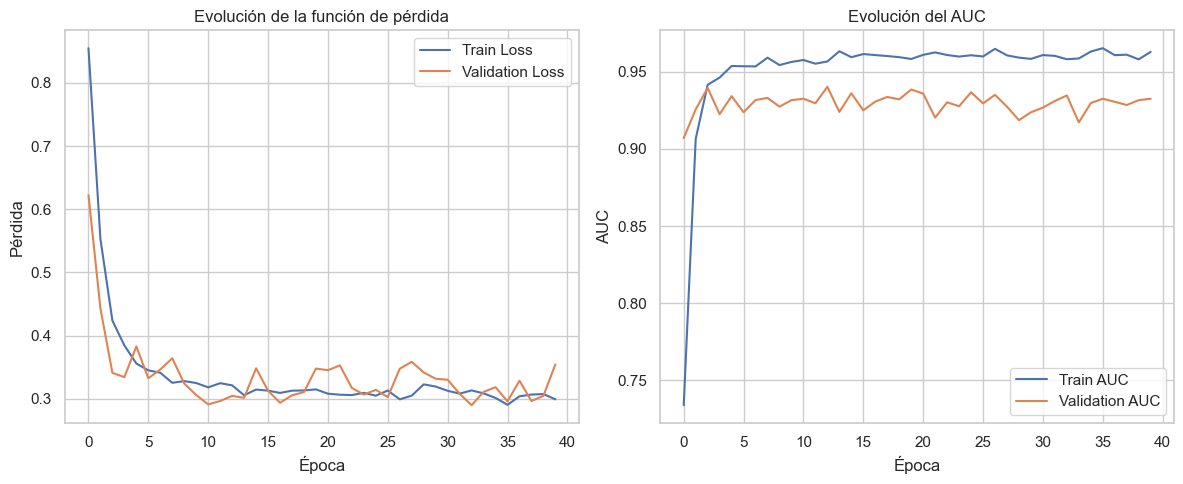

0.3543453812599182 0.9325795769691467 0.1607142835855484 0.75 0.26470587946551893


Train  Validation
Loss        0.30        0.35
Accuracy    0.92        0.88
Precision   0.88        0.16
Recall      0.96        0.75
AUC         0.96        0.93
F1-score    0.92        0.26

In [51]:
plot_training_history(history_turner_D2)
df_metrics_D2, val_loss_D2, val_auc_D2, val_precision_D2, val_recall_D2, f1_val_D2 = evaluacion_modelo(history_turner_D2)
print(val_loss_D2, val_auc_D2, val_precision_D2, val_recall_D2, f1_val_D2)
df_metrics_D2

##### 3.3 Entrenamiento con dataset de selección de variables PCA sin balanceo

In [38]:
best_model_tuner_D3, history_turner_D3 = busqueda_hiperparams_tuner(X_train_pca, y_train, X_val_pca, y_val)

Trial 90 Complete [00h 00m 09s]
val_loss: 0.114965058863163

Best val_loss So Far: 0.10507414489984512
Total elapsed time: 00h 04m 38s
Mejores hiperparámetros encontrados: {'units_1': 32, 'dropout_1': 0.30000000000000004, 'units_2': 16, 'dropout_2': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0028325744723759023, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0075'}
Epoch 1/40
52/52 [==============================] - 1s 11ms/step - loss: 0.9150 - accuracy: 0.7835 - precision: 0.0336 - recall: 0.2200 - auc: 0.5304 - val_loss: 0.5405 - val_accuracy: 0.9707 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5581
Epoch 2/40
52/52 [==============================] - 0s 2ms/step - loss: 0.4851 - accuracy: 0.9701 - precision: 0.6667 - recall: 0.0400 - auc: 0.7050 - val_loss: 0.4014 - val_accuracy: 0.9707 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7084
Epoch 3/40
52/52 [==============================

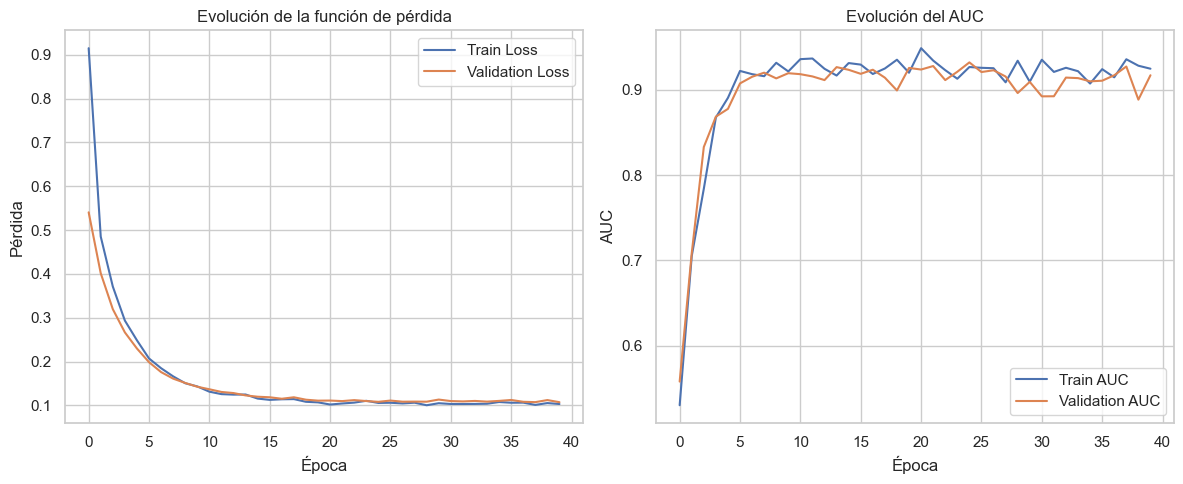

0.10726682841777802 0.9168760776519775 0.0 0.0 0


Train  Validation
Loss        0.10        0.11
Accuracy    0.98        0.97
Precision   0.92        0.00
Recall      0.22        0.00
AUC         0.92        0.92
F1-score    0.35        0.00

In [42]:
plot_training_history(history_turner_D3)
df_metrics_D3, val_loss_D3, val_auc_D3, val_precision_D3, val_recall_D3, f1_val_D3 = evaluacion_modelo(history_turner_D3)
print(val_loss_D3, val_auc_D3, val_precision_D3, val_recall_D3, f1_val_D3)
df_metrics_D3

##### 3.4 Entrenamiento con dataset de selección de variables PCA con balanceo (SMOTE)

In [44]:
best_model_tuner_D4, history_turner_D4 = busqueda_hiperparams_tuner(X_train_pca_bal, y_train_bal, X_val_pca, y_val)

Trial 90 Complete [00h 00m 10s]
val_loss: 0.4031321406364441

Best val_loss So Far: 0.2514355480670929
Total elapsed time: 00h 05m 39s
Mejores hiperparámetros encontrados: {'units_1': 16, 'dropout_1': 0.6000000000000001, 'units_2': 32, 'dropout_2': 0.4, 'optimizer': 'nadam', 'learning_rate': 0.010731058974110062, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0022'}
Epoch 1/40


100/100 [==============================] - 2s 6ms/step - loss: 0.6660 - accuracy: 0.7607 - precision: 0.7589 - recall: 0.7642 - auc: 0.8497 - val_loss: 0.4480 - val_accuracy: 0.8561 - val_precision: 0.1594 - val_recall: 0.9167 - val_auc: 0.9261
Epoch 2/40
100/100 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8858 - precision: 0.8689 - recall: 0.9088 - auc: 0.9424 - val_loss: 0.4048 - val_accuracy: 0.8512 - val_precision: 0.1549 - val_recall: 0.9167 - val_auc: 0.9214
Epoch 3/40
100/100 [==============================] - 0s 2ms/step - loss: 0.3547 - accuracy: 0.9097 - precision: 0.8759 - recall: 0.9547 - auc: 0.9546 - val_loss: 0.2759 - val_accuracy: 0.9000 - val_precision: 0.1778 - val_recall: 0.6667 - val_auc: 0.9367
Epoch 4/40
100/100 [==============================] - 0s 2ms/step - loss: 0.3396 - accuracy: 0.9145 - precision: 0.8792 - recall: 0.9610 - auc: 0.9597 - val_loss: 0.3303 - val_accuracy: 0.8951 - val_precision: 0.1961 - val_recall: 0.8333 - val

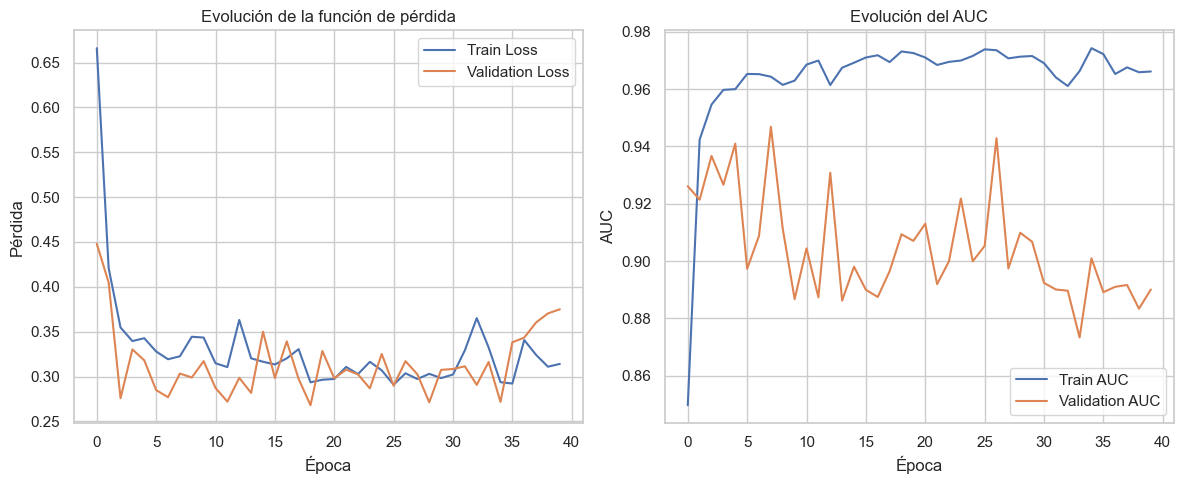

0.37500354647636414 0.8900754451751709 0.20000000298023224 0.75 0.31578947739918145


Train  Validation
Loss        0.31        0.38
Accuracy    0.92        0.90
Precision   0.89        0.20
Recall      0.97        0.75
AUC         0.97        0.89
F1-score    0.93        0.32

In [49]:
plot_training_history(history_turner_D4)
df_metrics_D4, val_loss_D4, val_auc_D4, val_precision_D4, val_recall_D4, f1_val_D4 = evaluacion_modelo(history_turner_D4)
print(val_loss_D4, val_auc_D4, val_precision_D4, val_recall_D4, f1_val_D4)
df_metrics_D4

***
## 5. Visualización de resultados

Parte de los resultados ya fueron presentados y discutidos en la sección anterior, como la evolución de la curva de la función de perdida y la evolución del AUC en los datasets de entrenamiento y validación, por lo que a continuación se comparan los modelos en terminos de desempeño.

        Modelo  val_loss   val_auc  val_precision  val_recall    f1_val
0      Base_D1  0.269195  0.685092       0.375000    0.250000  0.300000
1  Base+Reg_D1  0.107546  0.921692       0.500000    0.083333  0.142857
2    Manual_D1  0.115838  0.912584       0.000000    0.000000  0.000000
3        RS_D1  0.115197  0.906826       0.000000    0.000000  0.000000
4        GS_D1  0.114144  0.915725       0.000000    0.000000  0.000000
5    Turner_D1  0.105524  0.922006       0.000000    0.000000  0.000000
6    Turner_D2  0.354345  0.932580       0.160714    0.750000  0.264706
7    Turner_D3  0.107267  0.916876       0.000000    0.000000  0.000000
8    Turner_D4  0.375004  0.890075       0.200000    0.750000  0.315789


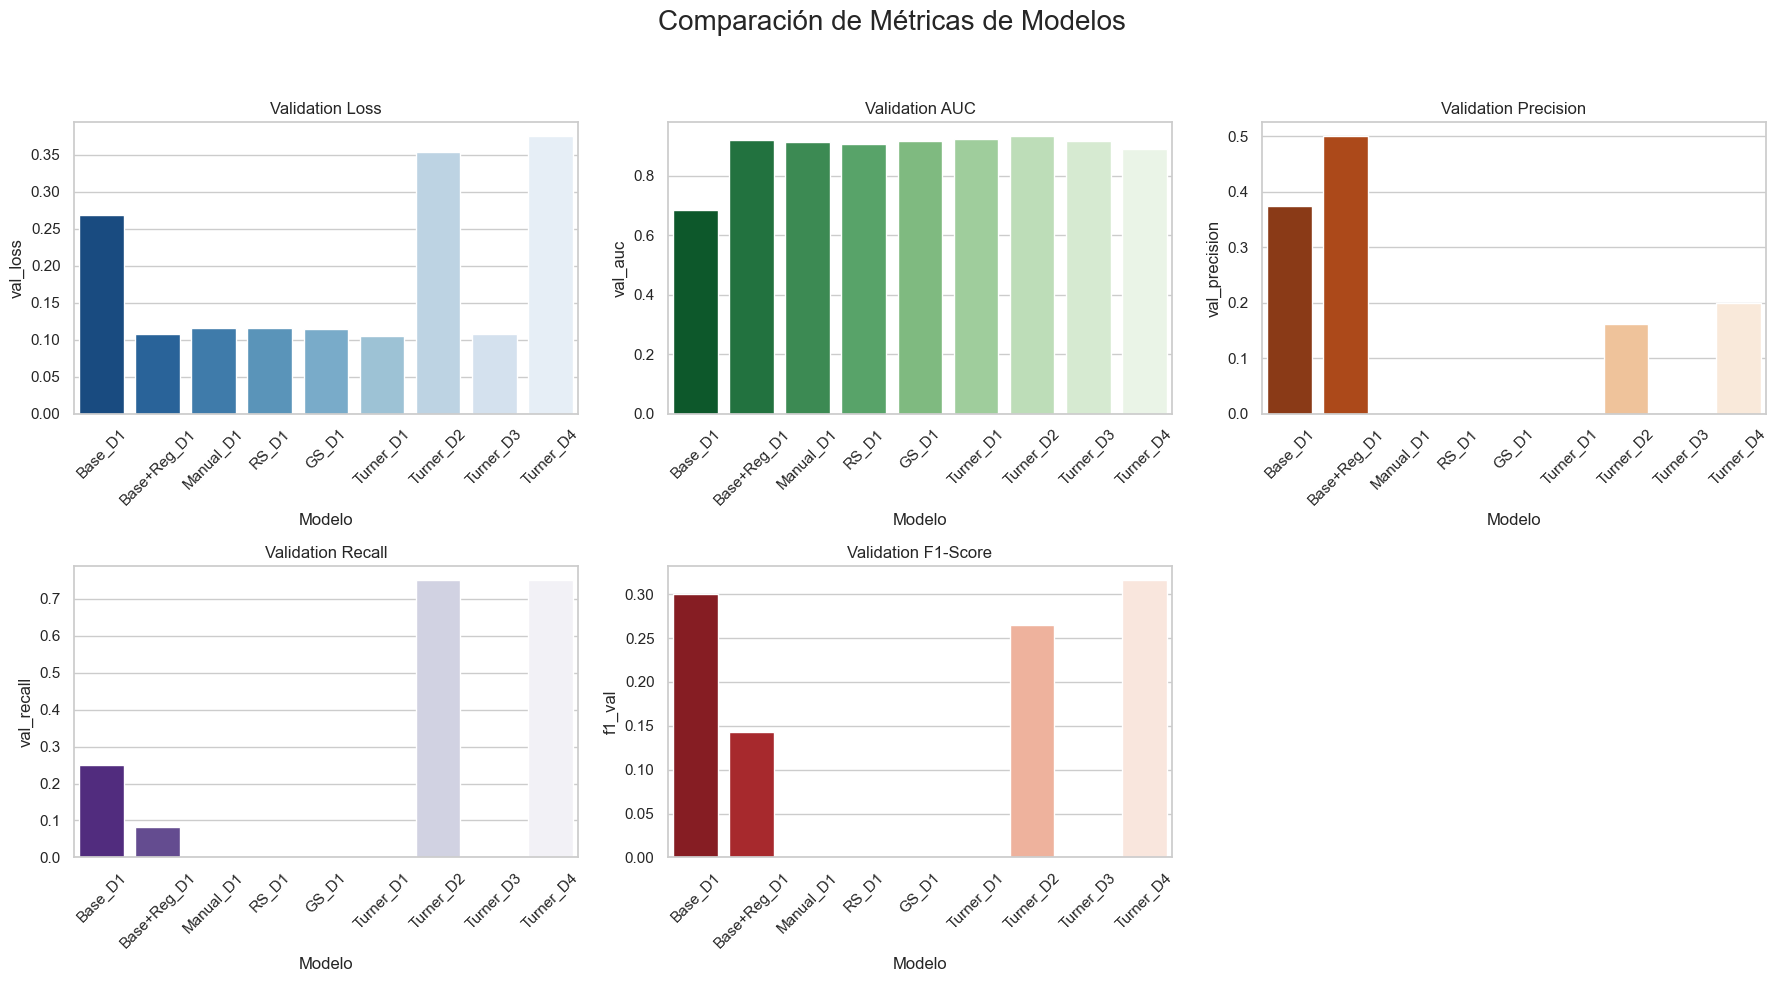

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de las métricas
datos = [
    0.2691952586174011, 0.685092031955719, 0.375, 0.25, 0.3, #Base
    0.10754568874835968, 0.9216917157173157, 0.5, 0.0833333358168602, 0.1428571465064068, #Base+reg
    0.11583803594112396, 0.9125838279724121, 0.0, 0.0, 0, #Manual
    0.11519674211740494, 0.9068257808685303, 0.0, 0.0, 0, #RS
    0.11414438486099243, 0.915724515914917, 0.0, 0.0, 0, #GS
    0.1055237203836441, 0.9220058917999268, 0.0, 0.0, 0, #Turner_D1
    0.3543453812599182, 0.9325795769691467, 0.1607142835855484, 0.75, 0.2647058794655189, #Turner_D2
    0.10726682841777802, 0.9168760776519775, 0.0, 0.0, 0, #Turner_D3
    0.37500354647636414, 0.8900754451751709, 0.20000000298023224, 0.75, 0.31578947739918145 #Turner_D4
]

# Lista de nombres de los modelos
nombres_modelos = [
    'Base_D1', 'Base+Reg_D1', 'Manual_D1', 
    'RS_D1', 'GS_D1', 'Turner_D1',
    'Turner_D2', 'Turner_D3', 'Turner_D4'
]

# Crear el DataFrame
df_metrics_base = pd.DataFrame(
    [datos[i:i+5] for i in range(0, len(datos), 5)], 
    columns=['val_loss', 'val_auc', 'val_precision', 'val_recall', 'f1_val']
)

# Asignar los nombres personalizados
df_metrics_base['Modelo'] = nombres_modelos[:len(df_metrics_base)]

# Reordenar columnas
df_metrics_base = df_metrics_base[['Modelo', 'val_loss', 'val_auc', 'val_precision', 'val_recall', 'f1_val']]

print(df_metrics_base)

# Graficar
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparación de Métricas de Modelos', fontsize=20)

# Gráfica val_loss
sns.barplot(x='Modelo', y='val_loss', data=df_metrics_base, ax=axs[0,0], palette="Blues_r")
axs[0,0].set_title('Validation Loss')
axs[0,0].tick_params(axis='x', rotation=45)

# Gráfica val_auc
sns.barplot(x='Modelo', y='val_auc', data=df_metrics_base, ax=axs[0,1], palette="Greens_r")
axs[0,1].set_title('Validation AUC')
axs[0,1].tick_params(axis='x', rotation=45)

# Gráfica val_precision
sns.barplot(x='Modelo', y='val_precision', data=df_metrics_base, ax=axs[0,2], palette="Oranges_r")
axs[0,2].set_title('Validation Precision')
axs[0,2].tick_params(axis='x', rotation=45)

# Gráfica val_recall
sns.barplot(x='Modelo', y='val_recall', data=df_metrics_base, ax=axs[1,0], palette="Purples_r")
axs[1,0].set_title('Validation Recall')
axs[1,0].tick_params(axis='x', rotation=45)

# Gráfica f1_val
sns.barplot(x='Modelo', y='f1_val', data=df_metrics_base, ax=axs[1,1], palette="Reds_r")
axs[1,1].set_title('Validation F1-Score')
axs[1,1].tick_params(axis='x', rotation=45)

# Eliminar la gráfica vacía
fig.delaxes(axs[1,2])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Conclusiones desempeño**
Al analizar los resultados obtenidos para los 9 modelos, se observa una clara variabilidad en su desempeño, dependiendo de las métricas clave: val_loss, val_auc, val_precision, val_recall y f1_val.

En términos de pérdida de validación (val_loss), Turner_D1 destaca con el valor más bajo de 0.105, lo que indica una mayor capacidad de generalización y un mejor ajuste a los datos en comparación con otros modelos. Sin embargo, es importante destacar que un val_loss bajo no siempre es indicador de un buen desempeño, por ejemplo Turner_D3 presenta un bajo valor, pero bajo rendimiento en otras métricas. Cabe destacar que la grafica de perdida de Turner_D4 se observa evidencia de overfitting.

En cuanto a valor de AUC, val_auc), que mide la capacidad del modelo para distinguir entre clases, Turner_D2 sobresale con un 0.933, y en general todos los modelos son para separar las clases, lo que es esencial para tareas donde la discriminación entre clases es crítica.

Finalmente, la métrica más representativa del rendimiento global del modelo, el F1-score (f1_val), que combina precisión y recall en un solo valor, muestra que Turner_D4 es el modelo más equilibrado con un f1_val de 0.316, lo que lo convierte en un buen candidato cuando se busca un balance entre precisión y recall. A pesar de sus limitaciones en precision, su alto recall le permite obtener un buen f1. Los modelos con f1_val cercanos a cero (como Manual_D1, RS_D1, y Turner_D1) no son efectivos en ningún aspecto relevante de la predicción.

En conclusión, Turner_D2 y Turner_D4 se destacan como los modelos más apropiados para la predicción de bancarrota. Mientras que Turner_D2 es más efectivo para discriminar entre clases y tiene una alta capacidad para identificar correctamente los casos en riesgo, Turner_D4 ofrece un buen balance entre la captura de positivos y la reducción de falsos negativos, lo que lo hace particularmente útil para prevenir quiebras antes de que se conviertan en un problema más grave. Por lo tanto, La elección final del modelo depende también de la tolerancia a los falsos positivos.


## Bibliografía

Altman, E. I. (1968).
Financial Ratios, Discriminant Analysis and the Prediction of Corporate Bankruptcy.
Journal of Finance, 23(4), 589-609.


Bodie, Z., Kane, A., & Marcus, A. J. (2014).
Investments.
McGraw-Hill Education.